### Pipeline for a single spikeglx session
- Load an exctractor for visualization of the data
- Sort it using kilosort

In [1]:
%matplotlib inline

import os
import glob
import logging
import pickle
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy import signal

from matplotlib import pyplot as plt
from importlib import reload

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)


os.environ["KILOSORT2_PATH"] = '/mnt/cube/earneodo/repos/Kilosort2'
os.environ["KILOSORT_PATH"] = '/mnt/cube/earneodo/repos/Kilosort'
os.environ["NPY_MATLAB_PATH"] = '/mnt/cube/earneodo/repos/npy-matlab'

In [2]:
import pickle

In [3]:
from ceciestunepipe.file import bcistructure as et
from ceciestunepipe.util import sglxutil as sglu
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import readSGLX as rsgl
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import spikeglxrecordingextractor as sglex

h5py version > 2.10.0. Some extractors might not work properly. It is recommended to downgrade to version 2.10.0: 
>>> pip install h5py==2.10.0


In [4]:
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
logger.info('all modules loaded')

2021-08-15 06:37:55,107 root         INFO     all modules loaded


In [5]:
si

<module 'spikeinterface' from '/home/earneodo/anaconda3/lib/python3.8/site-packages/spikeinterface/__init__.py'>

In [6]:
### Session parameters and raw files

In [7]:
reload(et)

bird = 's_b1253_21'
all_bird_sess = et.list_sessions(bird)
all_bird_sess

['2021-05-12',
 '2021-05-20',
 '2021-05-21',
 '2021-05-22',
 '2021-05-23',
 '2021-05-24',
 '2021-05-25',
 '2021-05-26',
 '2021-05-27',
 '2021-05-28',
 '2021-05-29',
 '2021-05-30',
 '2021-05-31',
 '2021-06-01',
 '2021-06-02',
 '2021-06-03',
 '2021-06-04',
 '2021-06-05',
 '2021-06-06',
 '2021-06-07',
 '2021-06-08',
 '2021-06-09',
 '2021-06-10',
 '2021-06-11',
 '2021-06-12',
 '2021-06-13',
 '2021-06-14',
 '2021-06-15',
 '2021-06-16',
 '2021-06-17',
 '2021-06-18',
 '2021-06-19',
 '2021-06-20',
 '2021-06-21',
 '2021-06-22',
 '2021-06-23',
 '2021-06-24',
 '2021-06-25',
 '2021-06-26',
 '2021-06-27',
 '2021-06-28',
 '2021-06-29',
 '2021-06-30',
 '2021-07-01',
 '2021-07-02',
 '2021-07-03',
 '2021-07-04',
 '2021-07-05',
 '2021-07-06',
 '2021-07-07',
 '2021-07-08',
 '2021-07-09',
 '2021-07-10',
 '2021-07-11',
 '2021-07-12',
 '2021-07-13',
 '2021-07-14',
 '2021-07-15',
 '2021-07-16',
 '2021-07-17',
 '2021-07-18',
 '2021-07-19',
 '2021-07-20',
 '2021-07-21',
 '2021-07-22',
 '2021-07-23',
 '2021-07-

In [8]:
reload(et)
sess_par = {'bird': 's_b1253_21',
           'sess': '2021-06-14',
           'probe': 'probe_0',
           'sort': 2}

exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sort=sess_par['sort'])

ksort_folder = exp_struct['folders']['ksort']
raw_folder = exp_struct['folders']['sglx']

In [9]:
raw_folder

'/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx'

In [10]:
sess_epochs = et.list_sgl_epochs(sess_par)
sess_epochs

2021-08-15 06:38:00,446 ceciestunepipe.file.bcistructure INFO     {'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/s_b1253_21', 'raw': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14', 'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx', 'kwik': '/scratch/earneodo/s_b1253_21/sglx/kwik/2021-06-14', 'processed': '/mnt/sphere/speech_bci/processed_data/s_b1253_21/2021-06-14/sglx', 'derived': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx', 'tmp': '/scratch/earneodo/tmp', 'msort': '/scratch/earneodo/s_b1253_21/sglx/msort/2021-06-14', 'ksort': '/scratch/earneodo/s_b1253_21/sglx/ksort/2021-06-14'}, 'files': {'par': '/scratch/earneodo/s_b1253_21/sglx/ksort/2021-06-14/params.json', 'set': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx/settings.isf', 'rig': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx/rig.json', 'kwd': '/scratch/earneodo/s_b1253_21/sglx/kwik/2021-06-14/stream.kwd', 'kwik': '/scratch/earneodo/s_b1253_21/sgl

['0712_g0', '1255_g0', '1740_g0', '2118_g0']

In [11]:
### pick a session
reload(et)
reload(sglu)
epoch = sess_epochs[0] # g2 is the shortest

exp_struct = et.sgl_struct(sess_par, epoch)
sgl_folders, sgl_files = sglu.sgl_file_struct(exp_struct['folders']['sglx'])

In [12]:
sgl_folders

{'nidq': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx/0712_g0',
 'imec_0': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx/0712_g0/0712_g0_imec0'}

In [13]:
sgl_files

{'nidq': ['/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx/0712_g0/0712_g0_t0.nidq.meta'],
 'lf_0': ['/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx/0712_g0/0712_g0_imec0/0712_g0_t0.imec0.lf.meta'],
 'ap_0': ['/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx/0712_g0/0712_g0_imec0/0712_g0_t0.imec0.ap.meta']}

In [14]:
files_pd = pd.DataFrame(sgl_files)

In [15]:
files_pd

,nidq,lf_0,ap_0
0,/mnt/sphere/speech_bci/raw_data/s_b1253_21/202...,/mnt/sphere/speech_bci/raw_data/s_b1253_21/202...,/mnt/sphere/speech_bci/raw_data/s_b1253_21/202...


In [16]:
probe_id = int(sess_par['probe'].split('_')[-1])
i_run = 0

run_meta_files = {k: v[i_run] for k, v in sgl_files.items()}
run_recordings = {k: sglex.SpikeGLXRecordingExtractor(sglu.get_data_meta_path(v)[0]) for k, v in run_meta_files.items()}


#probe_data_folder = sgl_folder['imec'][probe_id]


### view the nidaq data

In [17]:
run_recordings['nidq']

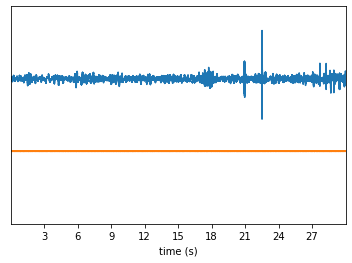

In [18]:
w_ts = sw.plot_timeseries(run_recordings['nidq'], channel_ids=[0, 1], trange=[0,30])

In [19]:
nidq_ttl = run_recordings['nidq'].get_ttl_events()

2021-08-15 06:38:12,461 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0


In [20]:
run_recordings['lf_0']._raw.shape

(385, 51463406)

In [21]:
syn_ch_arr = run_recordings['lf_0']._raw[-1, :]

np.mean(syn_ch_arr)

32.0016477727883

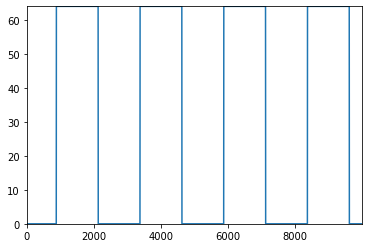

In [22]:
plt.plot(syn_ch_arr[:10000])

In [23]:
run_recordings['ap_0']._meta

{'acqApLfSy': '384,384,1',
 'appVersion': '20200520',
 'fileCreateTime': '2021-06-14T07:12:43',
 'fileName': 'D:/raw_data/s_b1253_21/2021-06-14/sglx/0712_g0/0712_g0_imec0/0712_g0_t0.imec0.ap.bin',
 'fileSHA1': 'CE93A7F297B6841CF46B8CC0DF7055A297CA7191',
 'fileSizeBytes': '475521865280',
 'fileTimeSecs': '20585.362133333332',
 'firstSample': '282824',
 'gateMode': 'Immediate',
 'imAiRangeMax': '0.6',
 'imAiRangeMin': '-0.6',
 'imCalibrated': 'true',
 'imDatApi': '1.20',
 'imDatBs_fw': '1.1.123',
 'imDatBsc_fw': '1.0.151',
 'imDatBsc_hw': '5.1',
 'imDatBsc_pn': 'NP2_HS_30',
 'imDatBsc_sn': '567',
 'imDatFx_hw': '1.2',
 'imDatFx_pn': 'NP2_FLEX_0',
 'imDatHs_fw': '5.3',
 'imDatHs_pn': '',
 'imDatHs_sn': '3701768989021720654',
 'imDatPrb_pn': 'PRB_1_4_0480_1',
 'imDatPrb_port': '4',
 'imDatPrb_slot': '4',
 'imDatPrb_sn': '19108322052',
 'imDatPrb_type': '0',
 'imLEDEnable': 'false',
 'imMaxInt': '512',
 'imRoFile': 'D:/imro/lf_500x_extref.imro',
 'imSampRate': '30000',
 'imStdby': '',
 'imT

## The digital and sync channel in the recording
- using the new methods in my version of readSGLX, spikeglxrecordingextractor

In [24]:
run_recordings['nidq']._raw.shape

(6, 411700466)

In [25]:
nidq_syn = rsgl.ExtractDigital(run_recordings['nidq']._raw, 0, 411700466, 0, [0], run_recordings['nidq']._meta)

In [26]:
nidq_syn.shape

(1, 411700466)

In [27]:
run_recordings['ap_0']._raw.shape

(385, 617560864)

In [28]:
nidq_hi=np.where(np.diff(nidq_syn)>0)
nidq_hi

(array([0, 0, 0, ..., 0, 0, 0]),
 array([     7031,     17031,     27030, ..., 411671456, 411681456,
        411691456]))

In [29]:
nidq_hi[0].shape

(41170,)

In [30]:
ap_syn = rsgl.ExtractDigital(run_recordings['ap_0']._raw, 0, 617560864, 0, [0], run_recordings['ap_0']._meta)

2021-08-15 06:41:50,778 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-08-15 06:41:50,779 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     allocated array for syn channel of size (617560864,)
2021-08-15 06:52:48,045 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Threshold for logical hi is 32.00164912004527


In [31]:
ap_hi=np.where(np.diff(ap_syn)>0)
ap_hi

(array([    10548,     25549,     40548, ..., 617517371, 617532370,
        617547371]),)

In [32]:
ap_hi[0].shape

(41170,)

2021-08-15 07:10:23,617 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0


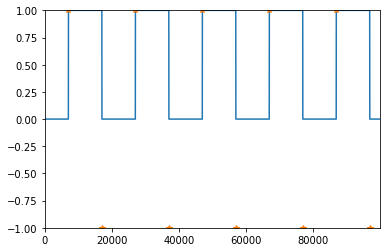

In [33]:
### the digital chan and the syn extraction of the nidq rec

nidq_syn = rsgl.ExtractDigital(run_recordings['nidq']._raw, 0, 100000, 0, [0], run_recordings['nidq']._meta)
nidq_syn_ttl = run_recordings['nidq'].get_ttl_events(channel_id=0, end_frame=100000)

plt.plot(nidq_syn.flatten())
plt.plot(*nidq_syn_ttl, '*')

In [34]:
nidq_syn_ttl

(array([ 7031, 17031, 27030, 37030, 47030, 57030, 67030, 77030, 87030,
        97030]),
 array([ 1, -1,  1, -1,  1, -1,  1, -1,  1, -1]))

2021-08-15 07:10:23,746 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-08-15 07:10:23,747 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     allocated array for syn channel of size (100000,)
2021-08-15 07:10:23,937 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Threshold for logical hi is 28.80192
2021-08-15 07:10:23,961 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-08-15 07:10:23,962 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-08-15 07:10:23,962 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     allocated array for syn channel of size (100000,)
2021-08-15 07:10:

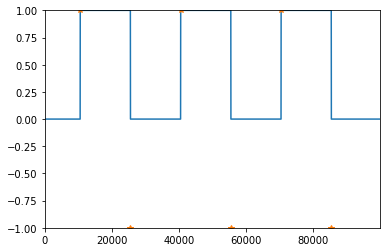

In [35]:
### the digital chan and the syn extraction of the nidq rec
ap_syn = rsgl.ExtractDigital(run_recordings['ap_0']._raw, 0, 100000, 0, [0], run_recordings['ap_0']._meta)
ap_syn_ttl = run_recordings['ap_0'].get_ttl_events(end_frame=100000)

plt.plot(ap_syn.flatten())
plt.plot(*ap_syn_ttl, '*')

In [36]:
exp_struct

{'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/0712_g0',
  'raw': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/0712_g0',
  'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx/0712_g0',
  'kwik': '/scratch/earneodo/s_b1253_21/sglx/kwik/2021-06-14/0712_g0',
  'processed': '/mnt/sphere/speech_bci/processed_data/s_b1253_21/2021-06-14/sglx/0712_g0',
  'derived': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx/0712_g0',
  'tmp': '/scratch/earneodo/tmp/0712_g0',
  'msort': '/scratch/earneodo/s_b1253_21/sglx/msort/2021-06-14/0712_g0',
  'ksort': '/scratch/earneodo/s_b1253_21/sglx/ksort/2021-06-14/0712_g0'},
 'files': {'par': '/scratch/earneodo/s_b1253_21/sglx/ksort/2021-06-14/0712_g0/params.json',
  'set': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx/settings.isf',
  'rig': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx/rig.json',
  'kwd': '/scratch/earneodo/s_b1253_21/sglx/kwik/2021-06-14/0712_g0/stream.kw

##### get the microphone channel

In [37]:
from ceciestunepipe.util.sound import spectral as sp
from scipy.io import wavfile

In [38]:
mic_chan_id = [0]

mic_stream = run_recordings['nidq'].get_traces(channel_ids=mic_chan_id)

In [39]:
mic_stream.shape

(1, 411700466)

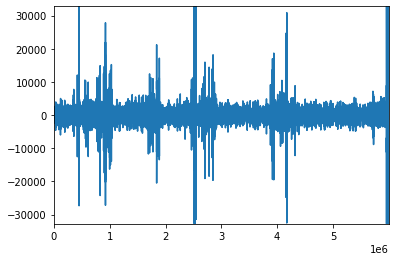

In [40]:
plt.plot(mic_stream[0, :6000000])

In [41]:
s_f = run_recordings['nidq'].get_effective_sf()[0]

In [42]:
run_recordings['nidq']._s_f_0

19999.75

In [43]:
s_f

19999.75

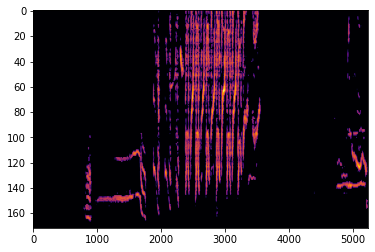

In [44]:
reload(sp)
f, t, s = sp.ms_spectrogram(mic_stream[0, 300000:400000], s_f)
plt.imshow(np.log(s[::-1]), aspect='auto', cmap='inferno')

In [45]:
mic_file_name = os.path.join(exp_struct['folders']['derived'], 'wav_mic.wav')
mic_file_name

'/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx/0712_g0/wav_mic.wav'

In [46]:
def mic_to_wav(recording_extractor, mic_chan_list: list, wav_path:str):
    # get the stream
    mic_stream = recording_extractor.get_traces(channel_ids=mic_chan_list)
    # make sure folder exists
    logger.info('saving {}-shaped array as wav in {}'.format(mic_stream.shape, wav_path))
    os.makedirs(os.path.split(wav_path)[0], exist_ok=True)
    # write it
    s_f = int(round(recording_extractor.get_sampling_frequency()/1000))*1000
    logger.info('sampling rate {}'.format(s_f))
    wavfile.write(wav_path, s_f, mic_stream.T)
    
    ## also save as numpy
    npy_path = wav_path.split('.')[0] + '.npy'
    logger.info('saving {}-shaped array as npy in {}'.format(mic_stream.shape, npy_path))
    np.save(npy_path, mic_stream.T)
    return s_f
    
s_f_wav = mic_to_wav(run_recordings['nidq'], mic_chan_id, mic_file_name)

2021-08-15 07:11:54,648 root         INFO     saving (1, 411700466)-shaped array as wav in /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx/0712_g0/wav_mic.wav
2021-08-15 07:11:54,650 root         INFO     sampling rate 20000
2021-08-15 07:12:24,817 root         INFO     saving (1, 411700466)-shaped array as npy in /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx/0712_g0/wav_mic.npy


#### plot a sample bout

In [47]:
## I see in the wav there is a bout starting in 354.64 (5 motifs)
## also in 13871.53 (6 motifs)
hand_bouts_s_list = [[15.67, 52.68], [64.84, 94.58], [111.02, 146.63], [179.46, 216.49], [283.67, 313.12],
                    [369.58, 397.95], [412.45, 445.62], [463.16, 492.1], [1327.1, 1361.1], [1375.9, 1408.62],
                     [1422.92, 1457], [1476.9, 1501.1], [1512.13, 1539.34], [1585.77, 1611.63], [1625.0, 1650.79], 
                     [1909.14, 1949.73], [1970.4, 2004.9], [2019.31, 2056.6], [2653.6, 2685.6], [2767.5, 2816.42],
                    [3010.18, 3042.15], [3130.47, 3181.86], [3213.9, 3244.54], [3274.5, 3305.18], [3331, 3364],
                    [3383.83, 3413.7], [3447.1, 3476.3], [3849.7, 3877.12], [3878.39, 3898.9], [3919.67, 3951.7],
                    [3973.89, 4005.8], [4028.38, 4063.42], [4136, 4180.2], [4227.18, 4269.95], [4321.5, 4363.22], 
                     [4993.97, 5037.25], [5110.29, 5155.6], [5263.8, 5295], [5439.42, 5473.1], [5560.35, 5592.9],
                     [6410.95, 6451.9], [6718.5, 6752.87], [6771.67, 6802.21], [16330.8, 16362.41], [16385.5, 16425.23],
                     [17007.44, 17041.41], [17237, 17278.45], [17388.3, 17442.17]]

In [48]:
hand_bouts_arr = np.array(hand_bouts_s_list)

In [49]:
np.diff(hand_bouts_arr)

array([[37.01],
       [29.74],
       [35.61],
       [37.03],
       [29.45],
       [28.37],
       [33.17],
       [28.94],
       [34.  ],
       [32.72],
       [34.08],
       [24.2 ],
       [27.21],
       [25.86],
       [25.79],
       [40.59],
       [34.5 ],
       [37.29],
       [32.  ],
       [48.92],
       [31.97],
       [51.39],
       [30.64],
       [30.68],
       [33.  ],
       [29.87],
       [29.2 ],
       [27.42],
       [20.51],
       [32.03],
       [31.91],
       [35.04],
       [44.2 ],
       [42.77],
       [41.72],
       [43.28],
       [45.31],
       [31.2 ],
       [33.68],
       [32.55],
       [40.95],
       [34.37],
       [30.54],
       [31.61],
       [39.73],
       [33.97],
       [41.45],
       [53.87]])

In [50]:
hand_bouts_arr[np.where(np.diff(hand_bouts_arr)>100)]

array([], dtype=float64)

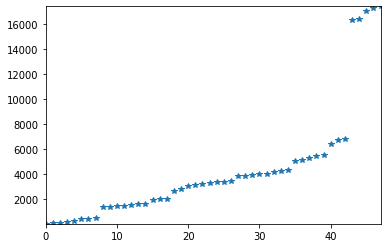

In [51]:
plt.plot(hand_bouts_arr[:,1], '*')

In [52]:
s_f
n_window = 256

In [53]:
s_f=20000

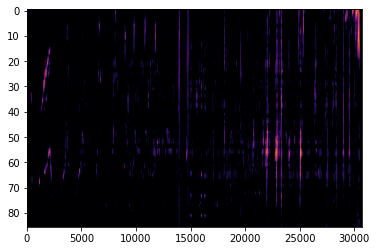

In [54]:
sample_bout = 23

temp_start_sample = int(hand_bouts_s_list[sample_bout][0] * s_f_wav)
temp_end_sample = int(hand_bouts_s_list[sample_bout][1] * s_f_wav)

template1 = mic_stream[0, temp_start_sample: temp_end_sample]

f, t, s1 = sp.ms_spectrogram(template1, s_f, n_window)

#plt.plot(template)
plt.imshow(np.log(s1[::-1]), aspect='auto', cmap='inferno')

In [55]:
s_f_wav

20000

In [56]:
# start of all bouts
# scale time linearly between the effective s_f and the khz_precise s_f used for the template matching
start_ms = np.array([int(x[0]*1000 * s_f_wav/s_f) for x in hand_bouts_s_list])
start_ms

array([   15670,    64840,   111020,   179460,   283670,   369580,
         412450,   463160,  1327100,  1375900,  1422920,  1476900,
        1512130,  1585770,  1625000,  1909140,  1970400,  2019310,
        2653600,  2767500,  3010180,  3130470,  3213900,  3274500,
        3331000,  3383830,  3447100,  3849700,  3878390,  3919670,
        3973890,  4028380,  4136000,  4227180,  4321500,  4993970,
        5110290,  5263800,  5439420,  5560350,  6410950,  6718500,
        6771670, 16330800, 16385500, 17007440, 17237000, 17388300])

In [57]:
len_ms = np.array([int(np.diff(x)*1000 * s_f_wav/s_f) for x in hand_bouts_s_list])
len_ms

array([37010, 29739, 35610, 37030, 29449, 28370, 33170, 28939, 34000,
       32719, 34079, 24199, 27209, 25860, 25789, 40589, 34500, 37289,
       32000, 48920, 31970, 51390, 30639, 30679, 33000, 29869, 29200,
       27420, 20510, 32029, 31910, 35039, 44199, 42769, 41720, 43279,
       45310, 31199, 33680, 32549, 40949, 34369, 30539, 31610, 39729,
       33970, 41450, 53869])

In [58]:
### make a dictionary
effective_sf = run_recordings['nidq'].get_effective_sf()[0]

# scale time linearly between the effective s_f and the khz_precise s_f used for the template matching
# start_ms = np.array([int(x[0]*1000 * 20000/s_f) for x in hand_bouts_s_list])
# start_ms

bout_dict = {'template': template1,
            's_f': s_f_wav, # s_f used to get the spectrogram
            's_f_nidq': run_recordings['nidq'].get_effective_sf()[0],
            's_f_ap_0': run_recordings['ap_0'].get_effective_sf()[0],
           'start_ms': start_ms,
             'len_ms': len_ms,
           'start_sample_naive': ( start_ms * s_f_wav * 0.001).astype(np.int),
           'start_sample_nidq': np.array([np.where(run_recordings['nidq']._t_0 > start)[0][0] for start in start_ms*0.001]),
           }

bout_dict['start_t_0'] = run_recordings['nidq']._t_0[bout_dict['start_sample_nidq']]

t0_naive = run_recordings['nidq']._t_0[bout_dict['start_sample_naive']]

<ipython-input-58-3bb75b4c54bf>:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'start_sample_naive': ( start_ms * s_f_wav * 0.001).astype(np.int),


In [59]:
run_recordings['nidq']._t_0

array([0.00000000e+00, 5.00006250e-05, 1.00001250e-04, ...,
       2.05852805e+04, 2.05852805e+04, 2.05852806e+04])

In [60]:
mot_dict_path = os.path.join(exp_struct['folders']['derived'], 'bout_dict.pkl')
with open(mot_dict_path, 'wb') as handle:
    pickle.dump(bout_dict, handle)

In [61]:
bout_dict

{'template': memmap([ -275,  -258,  -245, ..., -1737, -1734, -1750], dtype=int16),
 's_f': 20000,
 's_f_nidq': 19999.75,
 's_f_ap_0': 30000.0,
 'start_ms': array([   15670,    64840,   111020,   179460,   283670,   369580,
          412450,   463160,  1327100,  1375900,  1422920,  1476900,
         1512130,  1585770,  1625000,  1909140,  1970400,  2019310,
         2653600,  2767500,  3010180,  3130470,  3213900,  3274500,
         3331000,  3383830,  3447100,  3849700,  3878390,  3919670,
         3973890,  4028380,  4136000,  4227180,  4321500,  4993970,
         5110290,  5263800,  5439420,  5560350,  6410950,  6718500,
         6771670, 16330800, 16385500, 17007440, 17237000, 17388300]),
 'len_ms': array([37010, 29739, 35610, 37030, 29449, 28370, 33170, 28939, 34000,
        32719, 34079, 24199, 27209, 25860, 25789, 40589, 34500, 37289,
        32000, 48920, 31970, 51390, 30639, 30679, 33000, 29869, 29200,
        27420, 20510, 32029, 31910, 35039, 44199, 42769, 41720, 43279,
     

In [62]:
bout_dict['start_t_0']

array([1.56700459e+01, 6.48400105e+01, 1.11020038e+02, 1.79460043e+02,
       2.83670046e+02, 3.69580020e+02, 4.12450006e+02, 4.63160040e+02,
       1.32710004e+03, 1.37590005e+03, 1.42292004e+03, 1.47690001e+03,
       1.51213000e+03, 1.58577002e+03, 1.62500001e+03, 1.90914001e+03,
       1.97040003e+03, 2.01931004e+03, 2.65360002e+03, 2.76750004e+03,
       3.01018003e+03, 3.13047003e+03, 3.21390002e+03, 3.27450003e+03,
       3.33100004e+03, 3.38383005e+03, 3.44710004e+03, 3.84970002e+03,
       3.87839003e+03, 3.91967005e+03, 3.97389002e+03, 4.02838000e+03,
       4.13600005e+03, 4.22718004e+03, 4.32150002e+03, 4.99397002e+03,
       5.11029003e+03, 5.26380005e+03, 5.43942004e+03, 5.56035000e+03,
       6.41095004e+03, 6.71850003e+03, 6.77167005e+03, 1.63308000e+04,
       1.63855000e+04, 1.70074400e+04, 1.72370000e+04, 1.73883000e+04])

In [63]:
bout_dict['start_sample_nidq']

array([   313397,   1296784,   2220373,   3589156,   5673330,   7391508,
         8248897,   9263085,  26541669,  27517657,  28458045,  29537631,
        30242222,  31715004,  32499594,  38182323,  39407508,  40385696,
        53071337,  55349309,  60202848,  62608618,  64277197,  65489182,
        66619168,  67675755,  68941139,  76993038,  77566831,  78392421,
        79476807,  80566593,  82718967,  84542544,  86428920,  99878152,
       102204523, 105274685, 108787041, 111205610, 128217398, 134368321,
       135431708, 326611918, 327705904, 340144549, 344735691, 347761653])

In [64]:
bout_dict['start_sample_naive']

array([   313400,   1296800,   2220400,   3589200,   5673400,   7391600,
         8249000,   9263200,  26542000,  27518000,  28458400,  29538000,
        30242600,  31715400,  32500000,  38182800,  39408000,  40386200,
        53072000,  55350000,  60203600,  62609400,  64278000,  65490000,
        66620000,  67676600,  68942000,  76994000,  77567800,  78393400,
        79477800,  80567600,  82720000,  84543600,  86430000,  99879400,
       102205800, 105276000, 108788400, 111207000, 128219000, 134370000,
       135433400, 326616000, 327710000, 340148800, 344740000, 347766000])

### The time syncronization

In [65]:
# t_0 is n/s_f (measured s_f)
# t_prime is interpolation to a t_ref (the nidaq, for instance, but it should be the one with the highest s_f)

In [66]:
def compute_sf(ttl: tuple) -> np.array:
    ttl_arr = np.array(ttl)
    
    # get all the diffs betwenn edge ups and edge donws
    all_diff_arr = np.concatenate([np.diff(ttl_arr[0, ttl_arr[1]==j]) for j in [-1, 1]])
    
    return all_diff_arr

np.mean(compute_sf(ap_syn_ttl))

30000.0

#### use the imec af as a pattern

In [67]:
signal = 'ap_0'

syn_stream = rsgl.ExtractDigital(run_recordings[signal]._raw, 0, 120000, 0, [0], run_recordings[signal]._meta)

traces = run_recordings[signal].get_traces(end_frame=120000)
n_t = traces.shape[-1]

ttl_edge_tuple = run_recordings[signal].get_ttl_events(end_frame=120000)

s_f = np.mean(compute_sf(ttl_edge_tuple))


t_0 = np.arange(n_t)/s_f

t_0_edge = t_0[ttl_edge_tuple[0]]

2021-08-15 07:30:15,365 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-08-15 07:30:15,367 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     allocated array for syn channel of size (120000,)
2021-08-15 07:30:15,452 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Threshold for logical hi is 32.00213333333333
2021-08-15 07:30:15,456 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-08-15 07:30:15,457 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-08-15 07:30:15,458 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     allocated array for syn channel of size (120000,)
2021-08-

In [68]:
ttl_edge_tuple_pattern = ttl_edge_tuple
s_f_pattern = s_f
t_pattern = t_0
t_pattern_edge = t_0_edge
syn_stream_pattern = syn_stream

In [69]:
#plt.plot(t_0_edge, np.ones_like(t_0_edge), '*')

In [70]:
s_f_pattern, t_pattern, ttl_edge_tuple_pattern = run_recordings[signal].get_effective_sf()

In [71]:
ttl_edge_tuple_pattern[0].shape

(8,)

### debug the syn

In [72]:
ttl_edge_ap0 = run_recordings['ap_0'].get_ttl_events()


2021-08-15 07:30:57,451 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-08-15 07:30:57,452 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-08-15 07:30:57,453 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     allocated array for syn channel of size (617560864,)
2021-08-15 07:42:17,682 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Threshold for logical hi is 32.00164912004527


In [73]:
ttl_edge_nidq = run_recordings['nidq'].get_ttl_events()

2021-08-15 07:54:25,756 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0


#### fit the nidaq to the pattern

In [76]:
signal = 'nidq'
traces = run_recordings[signal].get_traces(end_frame=100000)
syn_stream = rsgl.ExtractDigital(run_recordings[signal]._raw, 0, 100000, 0, [0], run_recordings[signal]._meta)

n_t = traces.shape[-1]

ttl_edge_tuple = run_recordings[signal].get_ttl_events(end_frame=100000)

s_f = np.mean(compute_sf(ttl_edge_tuple))


t_0 = np.arange(n_t)/s_f

t_0_edge = t_0[ttl_edge_tuple[0]]

2021-08-15 09:38:00,934 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0


In [77]:
run_recordings[signal].syn_to_pattern(t_pattern, ttl_edge_tuple_pattern)

ValueError: Number of edges in the syn ttl events of pattern and target dont match

### make the time conversions using the syn_to_sgl_rec_exctractor method

In [78]:
run_recordings['lf_0'].syn_to_sgl_rec_exctractor(run_recordings['ap_0'], force_ttl=True)

2021-08-15 09:53:07,217 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-08-15 09:53:07,219 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-08-15 09:53:07,220 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     allocated array for syn channel of size (617560864,)
2021-08-15 10:03:30,831 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Threshold for logical hi is 32.00164912004527
2021-08-15 10:13:55,511 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-08-15 10:13:55,513 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from a

In [79]:
run_recordings['nidq'].syn_to_sgl_rec_exctractor(run_recordings['ap_0'], force_ttl=True)

2021-08-15 10:15:04,193 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-08-15 10:15:04,194 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-08-15 10:15:04,195 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     allocated array for syn channel of size (617560864,)
2021-08-15 10:24:50,120 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Threshold for logical hi is 32.00164912004527
2021-08-15 10:34:49,341 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0


In [80]:
run_recordings['ap_0'].syn_to_sgl_rec_exctractor(run_recordings['ap_0'], force_ttl=True)

2021-08-15 10:36:14,098 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-08-15 10:36:14,100 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-08-15 10:36:14,101 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     allocated array for syn channel of size (617560864,)
2021-08-15 10:49:21,067 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Threshold for logical hi is 32.00164912004527
2021-08-15 11:01:31,247 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-08-15 11:01:31,250 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from a

### plot the square syn signals in the three different timescales

In [81]:
# sig = 'lf_0'
# t_start_plot = 125

# t_plot = run_recordings[sig]._t_prime > t_start_plot
# plt.plot(run_recordings[sig]._t_prime[t_plot], run_recordings[sig]._dig[t_plot])

# sig = 'ap_0'
# t_plot = run_recordings[sig]._t_prime > t_start_plot
# plt.plot(run_recordings[sig]._t_prime[t_plot], run_recordings[sig]._dig[t_plot])

# sig = 'nidq'
# t_plot = run_recordings[sig]._t_prime > t_start_plot
# plt.plot(run_recordings[sig]._t_prime[t_plot], run_recordings[sig]._dig[t_plot])

## Save the mot_dict data

In [100]:
bout_dict_path = os.path.join(exp_struct['folders']['derived'], 'mot_dict_hand.pkl')
with open(bout_dict_path, 'wb') as handle:
    pickle.dump(bout_dict, handle)

In [118]:
bout_dict_path

'/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx/0712_g0/mot_dict_hand.pkl'

In [ ]:
recs_dict_path = os.path.join(exp_struct['folders']['derived'], 'rec_extractors_dict.pkl')

with open(recs_dict_path, 'wb') as handle:
    pickle.dump(run_recordings, handle)

In [121]:
run_recordings['nidq']

19999.729158569764

### The sorting

In [83]:
se.installed_recording_extractor_list

[spikeextractors.extractors.mdaextractors.mdaextractors.MdaRecordingExtractor,
 spikeextractors.extractors.biocamrecordingextractor.biocamrecordingextractor.BiocamRecordingExtractor,
 spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor,
 spikeextractors.extractors.klustaextractors.klustaextractors.KlustaRecordingExtractor,
 spikeextractors.extractors.kilosortextractors.kilosortextractors.KiloSortRecordingExtractor,
 spikeextractors.extractors.spykingcircusextractors.spykingcircusextractors.SpykingCircusRecordingExtractor,
 spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor.SpikeGLXRecordingExtractor,
 spikeextractors.extractors.phyextractors.phyextractors.PhyRecordingExtractor,
 spikeextractors.extractors.maxoneextractors.maxoneextractors.MaxOneRecordingExtractor,
 spikeextractors.extractors.mea1kextractors.mea1kextractors.Mea1kRecordingExtractor,
 spikeextractors.extractors.mcsh5recordingextractor.mcsh5rec

##### pick one ap stream, view it after running some of the toolkits

In [81]:
ap_extractor = run_recordings['ap_0']

###### view it raw

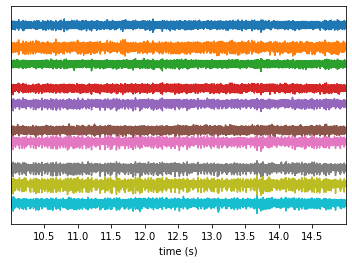

In [82]:
sw.plot_timeseries(ap_extractor, channel_ids=range(40, 50), trange=[10,15])

###### filtered

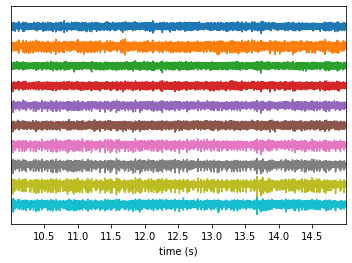

In [83]:
ap_extractor_filt = st.preprocessing.bandpass_filter(ap_extractor, freq_max=10000)
sw.plot_timeseries(ap_extractor_filt, channel_ids=range(40, 50), trange=[10,15])

###### cmr

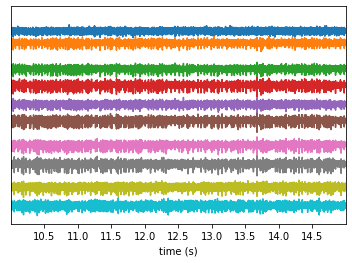

In [84]:
ap_extractor_cmr = st.preprocessing.common_reference(ap_extractor)
sw.plot_timeseries(ap_extractor_cmr, channel_ids=range(45, 55), trange=[10,15])

In [85]:
exp_struct['folders']

{'bird': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/0712_g0',
 'raw': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/0712_g0',
 'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx/0712_g0',
 'kwik': '/scratch/earneodo/s_b1253_21/sglx/kwik/2021-06-14/0712_g0',
 'processed': '/mnt/sphere/speech_bci/processed_data/s_b1253_21/2021-06-14/sglx/0712_g0',
 'derived': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx/0712_g0',
 'tmp': '/scratch/earneodo/tmp/0712_g0',
 'msort': '/scratch/earneodo/s_b1253_21/sglx/msort/2021-06-14/0712_g0',
 'ksort': '/scratch/earneodo/s_b1253_21/sglx/ksort/2021-06-14/0712_g0'}

In [84]:
import logging
import tempfile
import multiprocessing
import pickle
import os

N_JOBS_MAX = multiprocessing.cpu_count()

In [87]:
def run_spikesort(recording_extractor: se.RecordingExtractor, 
                  logger: logging.Logger,
                  sort_pickle_path: str,
                  tmp_dir: str, 
                  grouping_property: str=None,
                 sorting_method: str='kilosort2',
                 n_jobs_bin: int=N_JOBS_MAX,
                 chunk_mb: int=4096, restrict_to_gpu=None,
                 **sort_kwargs):

    logger.info("Grouping property: {}".format(grouping_property))
    logger.info("sorting method: {}".format(sorting_method))
    
    # try:
    if sorting_method == "kilosort2":
        # perform kilosort sorting
        sort_tmp_dir = os.path.join(tmp_dir, 'tmp_ks2')
        logger.info('Sorting tmp dir {}'.format(sort_tmp_dir))
        
        if restrict_to_gpu is not None:
            logger.info('Will set visible gpu devices {}'.format(restrict_to_gpu))
            os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
            os.environ["CUDA_VISIBLE_DEVICES"] = "{}".format(restrict_to_gpu)

            
        sort = ss.run_kilosort2(
            recording_extractor,
            car=True,
            output_folder=sort_tmp_dir,
            parallel=True,
            verbose=True,
            grouping_property=grouping_property,
            chunk_mb=chunk_mb,
            n_jobs_bin=n_jobs_bin,
            **sort_kwargs
        )
        
    else:
        raise NotImplementedError('Only know how to sort kilosort2 for now, \
                                        will deal with {} later'.format(sorting_method))
        
    logger.info('done sorting')
    
    # save sort
    logger.info("Saving sort {}".format(sort_pickle_path))
    with open(sort_pickle_path, "wb") as output:
        pickle.dump(sort, output, pickle.HIGHEST_PROTOCOL)
    logger.info("Sorting output saved to {}".format(sort_pickle_path))
      
#     # get templates and max channel
#     logger.info("Getting templates")
#     templates = st.postprocessing.get_unit_templates(
#         recording_extractor,
#         sort,
#         max_spikes_per_unit=200,
#         save_as_property=True,
#         verbose=True,
#         n_jobs=n_jobs_bin,
#         grouping_property=grouping_property,
#     )
    
#     logger.info("Getting main channel")
#     max_chan = st.postprocessing.get_unit_max_channels(
#         recording_extractor, 
#         sort, 
#         save_as_property=True, 
#         verbose=True, 
#         n_jobs=n_jobs_bin
#     )   
    
    # save sort again with all that processed data
    sort_temp_pickle_path = sort_pickle_path + '.dump.pkl'
    logger.info("Saving sort {}".format(sort_temp_pickle_path))
    sort.dump_to_pickle(sort_temp_pickle_path)
    
    return sort

In [88]:
ss.__version__

'0.4.3'

In [89]:
# ks_params = {'kilo_version': 2,
#              'use_gpu': 1,
#             'auto_merge': 1,
#             'filt_per_chan': 4,
#             's_f': int(s_f),
#             'spkTh': -4,
#             'minFR': 1/100,
#             }

In [90]:
default_ks2_params = ss.Kilosort2Sorter.default_params()
default_ks2_params

{'detect_threshold': 6,
 'projection_threshold': [10, 4],
 'preclust_threshold': 8,
 'car': True,
 'minFR': 0.1,
 'minfr_goodchannels': 0.1,
 'freq_min': 150,
 'sigmaMask': 30,
 'nPCs': 3,
 'ntbuff': 64,
 'nfilt_factor': 4,
 'NT': None,
 'keep_good_only': False,
 'chunk_mb': 500,
 'n_jobs_bin': 1}

##### manually enter ksort params

In [91]:
ks2_params = {'minFR': 0.01,
             'minfr_goodchannels': 0.01}

In [92]:
tmp_loc = exp_struct['folders']['ksort']
tmp_loc

'/scratch/earneodo/s_b1253_21/sglx/ksort/2021-06-14/0712_g0'

In [85]:
sort_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'sort_ks2.pickle')

#sort = run_spikesort(ap_extractor, logger, sort_pickle_path, tmp_loc, restrict_to_gpu=1, **ks2_params)

### load the sort

In [86]:
sort_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'sort_ks2.pickle.dump.pkl')
sort_pickle_path

'/scratch/earneodo/s_b1253_21/sglx/ksort/2021-06-14/0712_g0/sort_ks2.pickle.dump.pkl'

In [95]:
#sort_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'sort_ks2.pickle.dump.pkl')
#print(sort_pickle_path)
#loaded_sort = se.load_extractor_from_pickle(sort_pickle_path)

In [96]:
### load the sort directly from kilosort npy files
from ceciestunepipe.util.spike import kilosort as ks

In [97]:
reload(ks)

<module 'ceciestunepipe.util.spike.kilosort' from '/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/spike/kilosort.py'>

In [98]:
!ls /scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201106/2500r250a_3500_dir_g0/tmp_ks2/

ls: cannot access '/scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201106/2500r250a_3500_dir_g0/tmp_ks2/': No such file or directory


### plot a raster

In [102]:
bout_dict

{'template': memmap([ -275,  -258,  -245, ..., -1737, -1734, -1750], dtype=int16),
 's_f': 20000,
 's_f_nidq': 19999.75,
 's_f_ap_0': 30000.0,
 'start_ms': array([   15670,    64840,   111020,   179460,   283670,   369580,
          412450,   463160,  1327100,  1375900,  1422920,  1476900,
         1512130,  1585770,  1625000,  1909140,  1970400,  2019310,
         2653600,  2767500,  3010180,  3130470,  3213900,  3274500,
         3331000,  3383830,  3447100,  3849700,  3878390,  3919670,
         3973890,  4028380,  4136000,  4227180,  4321500,  4993970,
         5110290,  5263800,  5439420,  5560350,  6410950,  6718500,
         6771670, 16330800, 16385500, 17007440, 17237000, 17388300]),
 'len_ms': array([37010, 29739, 35610, 37030, 29449, 28370, 33170, 28939, 34000,
        32719, 34079, 24199, 27209, 25860, 25789, 40589, 34500, 37289,
        32000, 48920, 31970, 51390, 30639, 30679, 33000, 29869, 29200,
        27420, 20510, 32029, 31910, 35039, 44199, 42769, 41720, 43279,
     

In [103]:
# samples in nidq stream
# corresponding times in nidq stream tprime
nidq_samples = bout_dict['start_sample_nidq']
nidq_samples = bout_dict['start_sample_naive']

t_mot_prime = run_recordings['nidq']._t_prime[nidq_samples]

t_pre = -0.5
t_post = 1.5

t_range_arr = np.vstack([t_mot_prime + t_pre, t_mot_prime + t_post]).T

t_range_arr

array([[1.51702583e+01, 1.71702583e+01],
       [6.43409580e+01, 6.63409580e+01],
       [1.10521544e+02, 1.12521544e+02],
       [1.78962478e+02, 1.80962478e+02],
       [2.83173885e+02, 2.85173885e+02],
       [3.69085042e+02, 3.71085042e+02],
       [4.11955600e+02, 4.13955600e+02],
       [4.62666279e+02, 4.64666279e+02],
       [1.32661797e+03, 1.32861797e+03],
       [1.37541869e+03, 1.37741869e+03],
       [1.42243928e+03, 1.42443928e+03],
       [1.47642004e+03, 1.47842004e+03],
       [1.51165047e+03, 1.51365047e+03],
       [1.58529147e+03, 1.58729147e+03],
       [1.62452203e+03, 1.62652203e+03],
       [1.90866584e+03, 1.91066584e+03],
       [1.96992664e+03, 1.97192664e+03],
       [2.01883731e+03, 2.02083731e+03],
       [2.65313590e+03, 2.65513590e+03],
       [2.76703741e+03, 2.76903741e+03],
       [3.00972072e+03, 3.01172072e+03],
       [3.13001231e+03, 3.13201231e+03],
       [3.21344349e+03, 3.21544349e+03],
       [3.27404427e+03, 3.27604427e+03],
       [3.330545

In [104]:
t0_naive

array([1.56701959e+01, 6.48408105e+01, 1.11021388e+02, 1.79462243e+02,
       2.83673546e+02, 3.69584620e+02, 4.12455156e+02, 4.63165790e+02,
       1.32711659e+03, 1.37591720e+03, 1.42293779e+03, 1.47691846e+03,
       1.51214890e+03, 1.58578982e+03, 1.62502031e+03, 1.90916386e+03,
       1.97042463e+03, 2.01933524e+03, 2.65363317e+03, 2.76753459e+03,
       3.01021763e+03, 3.13050913e+03, 3.21394017e+03, 3.27454093e+03,
       3.33104164e+03, 3.38387230e+03, 3.44714309e+03, 3.84974812e+03,
       3.87843848e+03, 3.91971900e+03, 3.97393967e+03, 4.02843036e+03,
       4.13605170e+03, 4.22723284e+03, 4.32155402e+03, 4.99403243e+03,
       5.11035388e+03, 5.26386580e+03, 5.43948799e+03, 5.56041951e+03,
       6.41103014e+03, 6.71858398e+03, 6.77175465e+03, 1.63310041e+04,
       1.63857048e+04, 1.70076526e+04, 1.72372155e+04, 1.73885174e+04])

### Visualize a bout together with the neural traces

In [105]:
t_start = t0_naive

In [106]:
t_start

array([1.56701959e+01, 6.48408105e+01, 1.11021388e+02, 1.79462243e+02,
       2.83673546e+02, 3.69584620e+02, 4.12455156e+02, 4.63165790e+02,
       1.32711659e+03, 1.37591720e+03, 1.42293779e+03, 1.47691846e+03,
       1.51214890e+03, 1.58578982e+03, 1.62502031e+03, 1.90916386e+03,
       1.97042463e+03, 2.01933524e+03, 2.65363317e+03, 2.76753459e+03,
       3.01021763e+03, 3.13050913e+03, 3.21394017e+03, 3.27454093e+03,
       3.33104164e+03, 3.38387230e+03, 3.44714309e+03, 3.84974812e+03,
       3.87843848e+03, 3.91971900e+03, 3.97393967e+03, 4.02843036e+03,
       4.13605170e+03, 4.22723284e+03, 4.32155402e+03, 4.99403243e+03,
       5.11035388e+03, 5.26386580e+03, 5.43948799e+03, 5.56041951e+03,
       6.41103014e+03, 6.71858398e+03, 6.77175465e+03, 1.63310041e+04,
       1.63857048e+04, 1.70076526e+04, 1.72372155e+04, 1.73885174e+04])

In [107]:
plt.rcParams['lines.linewidth'] = 0.1
from ceciestunepipe.util.sound import spectral as sp
from ceciestunepipe.util import plotutil as pu

In [108]:
axes_pars = {'axes.labelpad': 5,
             'axes.titlepad': 5,
             'axes.titlesize': 'small',
             'axes.grid': False,
             'axes.xmargin': 0,
             'axes.ymargin': 0}

plt.rcParams.update(axes_pars)

In [109]:
#hvc_chans = list(range(290, 324)) #HVC
ra_chans = list(range(50, 101)) #RA

#neur_chans = hvc_chans + ra_chans
neur_chans = ra_chans

mot_start_ms = 4540 # in nidq time
#mot_start_ms = 7619983

pre_sec = -2.25
post_sec = 4 - pre_sec

# get coincident starts in samples
# the nidq from the time, then convert that time to t_prime
nidq_start = np.where(run_recordings['nidq']._t_prime > mot_start_ms*0.001)[0][0]
t_prime_start = run_recordings['nidq']._t_prime[nidq_start]
nidq_sf = run_recordings['nidq']._s_f_0

# the ap sample from the t_prime
ap_start = np.where(run_recordings['ap_0']._t_0 > t_prime_start)[0][0]
ap_sf = run_recordings['ap_0']._s_f_0

mic_arr = run_recordings['nidq'].get_traces(channel_ids=mic_chan_id, 
                                            start_frame=nidq_start + pre_sec*nidq_sf, 
                                            end_frame=nidq_start + post_sec*nidq_sf)


ap_arr_arr = run_recordings['ap_0'].get_traces(channel_ids=neur_chans, 
                                            start_frame=ap_start + pre_sec*ap_sf, 
                                            end_frame=ap_start + post_sec*ap_sf)

In [110]:
ap_start + pre_sec*ap_sf

68701.8008404586

In [111]:
ap_sf

30000.08851535173

<ipython-input-112-dcd387bbf1c8>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[1].pcolormesh(t, f, np.log(sxx), cmap='inferno')
<ipython-input-112-dcd387bbf1c8>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pu.plot_array(ap_arr_arr.T.astype(np.float), ax=ax[2])


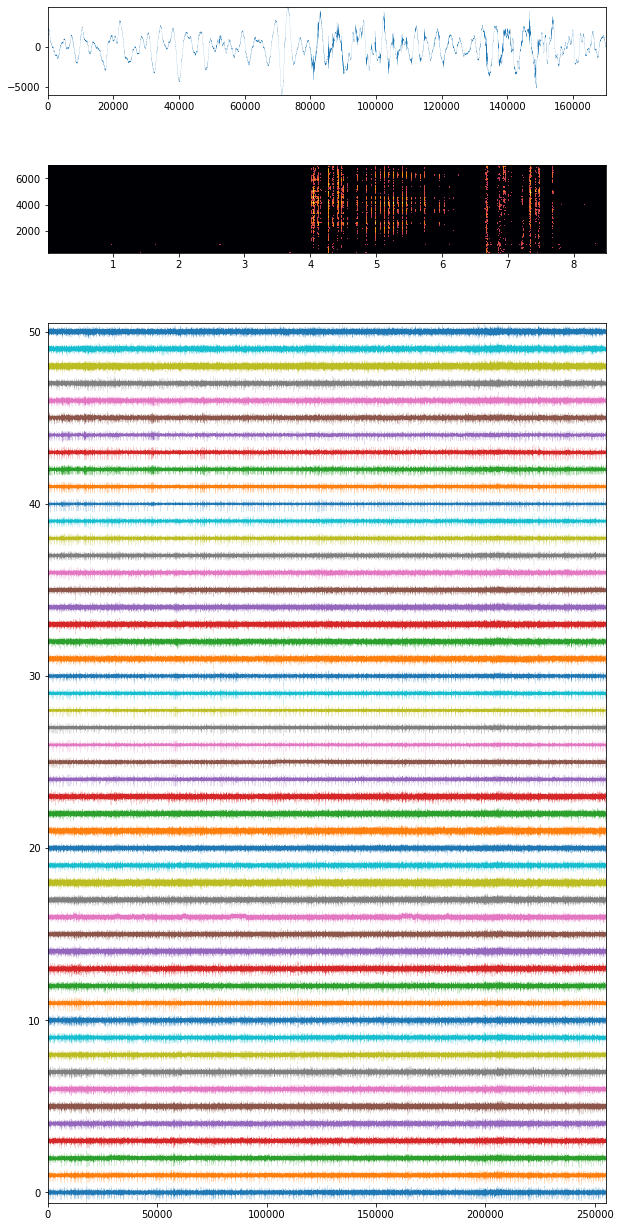

In [112]:
fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 1, 10]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), nidq_sf)

ax[0].plot(mic_arr.flatten())

ax[1].pcolormesh(t, f, np.log(sxx), cmap='inferno')

pu.plot_array(ap_arr_arr.T.astype(np.float), ax=ax[2])

### load the spikes

In [113]:
reload(ks)
clu_df, spk_df = ks.load_spikes(os.path.join(exp_struct['folders']['ksort'], 'tmp_ks2'))
spk_df.head(1)

NameError: name 'ks' is not defined

In [ ]:
## call the HVC/RA sites
#clu_df.loc[clu_df['main_chan'].isin(hvc_chans), 'nucleus'] = 'hvc'
ra_chans = np.arange(20, 120)
clu_df.loc[clu_df['main_chan'].isin(ra_chans), 'nucleus'] = 'ra'

#complete some redundancy in the spk_df
spk_df['nucelus'] = spk_df['clusters'].map(clu_df.set_index('cluster_id')['nucleus'])
spk_df['main_chan'] = spk_df['clusters'].map(clu_df.set_index('cluster_id')['main_chan'])
spk_df['kslabel'] = spk_df['clusters'].map(clu_df.set_index('cluster_id')['KSLabel'])

### save to pickle
spike_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'spk_df.pickle')
clu_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'clu_df.pickle')

spk_df.to_pickle(spike_pickle_path, protocol=4)
clu_df.to_pickle(clu_pickle_path, protocol=4)

In [ ]:
clu_df.head(1)

In [ ]:
clu_df_ra = clu_df[clu_df['nucleus']=='ra']
np.unique(clu_df_ra['cluster_id']).size

In [ ]:
# count the good ones
np.unique(clu_df[(clu_df['KSLabel']=='good') & (clu_df[clu_df['nucleus']=='ra'])]['cluster_id']).size

In [ ]:
# count the mua ones
np.unique(clu_df[clu_df['KSLabel']=='mua']['cluster_id']).size

In [ ]:
plt.plot(clu_df.loc[40, 'main_wav_7']);

In [ ]:
plt.plot(clu_df.loc[125, 'main_wav_7']);

### get motif alinged rasters

In [114]:
bout_dict

{'template': memmap([ -275,  -258,  -245, ..., -1737, -1734, -1750], dtype=int16),
 's_f': 20000,
 's_f_nidq': 19999.75,
 's_f_ap_0': 30000.0,
 'start_ms': array([   15670,    64840,   111020,   179460,   283670,   369580,
          412450,   463160,  1327100,  1375900,  1422920,  1476900,
         1512130,  1585770,  1625000,  1909140,  1970400,  2019310,
         2653600,  2767500,  3010180,  3130470,  3213900,  3274500,
         3331000,  3383830,  3447100,  3849700,  3878390,  3919670,
         3973890,  4028380,  4136000,  4227180,  4321500,  4993970,
         5110290,  5263800,  5439420,  5560350,  6410950,  6718500,
         6771670, 16330800, 16385500, 17007440, 17237000, 17388300]),
 'len_ms': array([37010, 29739, 35610, 37030, 29449, 28370, 33170, 28939, 34000,
        32719, 34079, 24199, 27209, 25860, 25789, 40589, 34500, 37289,
        32000, 48920, 31970, 51390, 30639, 30679, 33000, 29869, 29200,
        27420, 20510, 32029, 31910, 35039, 44199, 42769, 41720, 43279,
     

In [115]:
## use the starts in mot_dict start sample to get the t_prime
## get the samples for t_prime in the ap channel
## get those spikes

start_t_nidq = bout_dict['start_t_0']

bout_dict['start_t_ap_0'] = run_recordings['nidq']._t_prime[bout_dict['start_sample_nidq']]

mot_start_ap_samples = np.array([np.where(run_recordings['ap_0']._t_prime > start)[0][0] for start in bout_dict['start_t_ap_0']])

bout_dict['start_sample_ap_0'] = mot_start_ap_samples

In [117]:
mot_dict_path = os.path.join(exp_struct['folders']['derived'], 'bout_dict.pkl')
with open(mot_dict_path, 'wb') as handle:
    pickle.dump(bout_dict, handle)

In [ ]:
run_recordings['ap_0']._s_f_0

#### check alignment of the syn signals

In [ ]:
n_samples_ap = run_recordings['ap_0'].get_traces().shape[-1]
ap_syn = rsgl.ExtractDigital(run_recordings['ap_0']._raw, 0, n_samples_ap, 0, [0], run_recordings['ap_0']._meta)

n_samples_nidq = run_recordings['nidq'].get_traces().shape[-1]
nidq_syn= rsgl.ExtractDigital(run_recordings['nidq']._raw, 0, n_samples_nidq, 0, [0], run_recordings['nidq']._meta).flatten()

In [ ]:
bout_dict

#### plot together the syn signals of the ap, nidq channels, the mic raw trace for all the motifs

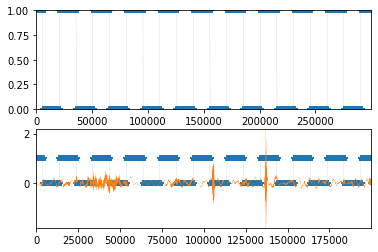

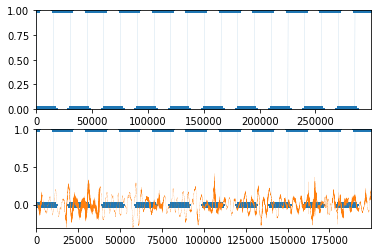

In [129]:
mot_idx = 8
sec_before = 0
sec_after = 10

for mot_idx in range(2):
    start_ap = bout_dict['start_sample_ap_0'][mot_idx] + int(run_recordings['ap_0']._s_f_0 * sec_before)
    end_ap = bout_dict['start_sample_ap_0'][mot_idx] + int(run_recordings['ap_0']._s_f_0 * sec_after)

    start_nidq = bout_dict['start_sample_nidq'][mot_idx] + int(run_recordings['nidq']._s_f_0 * sec_before)
    end_nidq = bout_dict['start_sample_nidq'][mot_idx] + int(run_recordings['nidq']._s_f_0 * sec_after)

    fig, ax = plt.subplots(nrows=2)
    ax[0].plot(ap_syn[start_ap: end_ap], '-*')
    ax[1].plot(nidq_syn[start_nidq: end_nidq], '-*')
    ax[1].plot(mic_stream[0, start_nidq: end_nidq]/15000)

In [ ]:
bout_dict['start_sample_ap_0'] + t_pre_samp

In [133]:
ap_samples

NameError: name 'ap_samples' is not defined

In [158]:
## get the actural raster for some clusters
def get_window_spikes(spk_df, clu_list, start_sample, end_sample):
    onset = start_sample
    offset = end_sample
    
    spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]
    
    spk_arr = np.zeros((clu_list.size, offset - onset))

    for i, clu_id in enumerate(clu_list):
        clu_spk_t = spk_t.loc[spk_t['clusters']==clu_id, 'times'].values
        spk_arr[i, clu_spk_t - onset] = 1
    return spk_arr
    
def get_rasters(spk_df, clu_list, start_samp_arr, span_samples):
    # returns np.array([n_clu, n_sample, n_trial])
    
    # get the window spikes for all of the clusters, for each of the start_samp_arr
    spk_arr_list = [get_window_spikes(spk_df, clu_list, x, x+span_samples) for x in start_samp_arr]
    return np.stack(spk_arr_list, axis=-1)
    
#clu_list = np.array([5, 6])
#clu_list = np.unique(clu_df.loc[clu_df['KSLabel']=='good', 'cluster_id'])
clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['nucleus'].isin(['hvc', 'ra'])), 
                                'cluster_id'])

t_pre = - 15
t_post = 15

s_f_ap = run_recordings['ap_0']._s_f_0
t_pre_samp = int(t_pre * s_f_ap)
t_post_samp = int(t_post * s_f_ap)


bout_idx = 0
start_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(run_recordings['ap_0']._s_f_0 * t_pre)
end_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(run_recordings['ap_0']._s_f_0 * t_post)

start_nidq = bout_dict['start_sample_nidq'][bout_idx] + int(run_recordings['nidq']._s_f_0 * t_pre)
end_nidq = bout_dict['start_sample_nidq'][bout_idx] + int(run_recordings['nidq']._s_f_0 * t_post)
    

#spk_arr = get_window_spikes(spk_df, clu_list, start_ap , end_ap)


#rast_arr = get_rasters(spk_df, clu_list, mot_dict['start_sample_ap_0'] + t_pre_samp, t_post_samp - t_pre_samp)

In [159]:
clu_list.size

45

In [1]:
def plot_as_raster(x, ax=None, t_0=None):
    #x is [n_events, n_timestamps] array
    n_y, n_t = x.shape
    
    row = np.ones(n_t) + 1
    t = np.arange(n_t)
    col = np.arange(n_y)
    
    frame = col[:, np.newaxis] + row[np.newaxis, :]
    x[x==0] = np.nan
    
    if ax is None:
        fig, ax = plt.subplots()
    
    raster = ax.scatter(t * x, frame * x, marker='.', facecolor='k', s=1, rasterized=False)
    if t_0 is not None:
        ax.axvline(x=t_0, color='red')
    return ax


#### what to plot
# pick units
clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['nucleus'].isin(['hvc', 'ra'])), 
                                'cluster_id'])

#pick window around a bout
t_pre = - 15
t_post = 15

s_f_ap = run_recordings['ap_0']._s_f_0
t_pre_samp = int(t_pre * s_f_ap)
t_post_samp = int(t_post * s_f_ap)


##Pick a bout
bout_idx = 2
start_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(run_recordings['ap_0']._s_f_0 * t_pre)
end_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(run_recordings['ap_0']._s_f_0 * t_post)

start_nidq = bout_dict['start_sample_nidq'][bout_idx] + int(run_recordings['nidq']._s_f_0 * t_pre)
end_nidq = bout_dict['start_sample_nidq'][bout_idx] + int(run_recordings['nidq']._s_f_0 * t_post)


# get the streams/spike array
spk_arr = get_window_spikes(spk_df, clu_list, int(start_ap), int(end_ap))
mic_arr = mic_stream[0, start_nidq: end_nidq]


# plot
fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 10, 1]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), nidq_sf)

#ax[0].plot(mic_arr.flatten())

ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')

plot_as_raster(spk_arr, t_0=int(-pre_sec*ap_sf), ax=ax[1])

bin_size_ms = 10
bin_size_sample = int(bin_size_ms * 0.001 *  run_recordings['ap_0']._s_f_0 )
psth = np.nansum(pu.coarse(spk_arr, bin_size_sample), axis=0)

ax[2].plot(psth);

plt.tight_layout()

NameError: name 'np' is not defined

In [178]:
from ceciestunepipe.util import plotutil as pu

In [183]:
bin_size_sample

300.0008851535173

/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/plotutil.py:66: RuntimeWarning: Mean of empty slice
  coarse_x = np.nanmean(exploded_x, axis=-1)


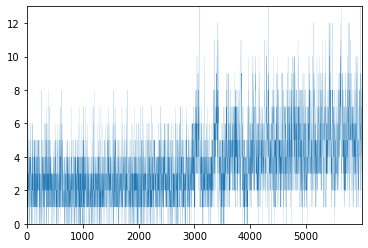

In [204]:
# plot a 'psth' of the summed activity of all units
bin_size_ms = 5
bin_size_sample = int(bin_size_ms * 0.001 *  run_recordings['ap_0']._s_f_0 )
psth = np.nansum(pu.coarse(spk_arr, bin_size_sample), axis=0)

plt.plot(psth);

In [198]:
np.nansum(psth, axis=0)

array([ 5.,  3.,  4., ..., 11., 12., 10.])

In [176]:
spk_arr.shape

(45, 900002)

In [161]:
fig_path = os.path.join(exp_struct['folders']['derived'], 'bout_1_raster_sua')
fig.savefig(fig_path+'.png')
fig.savefig(fig_path+'.eps')

### NOw same one for MUA

<ipython-input-205-b37c22246584>:37: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')
/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/plotutil.py:66: RuntimeWarning: Mean of empty slice
  coarse_x = np.nanmean(exploded_x, axis=-1)


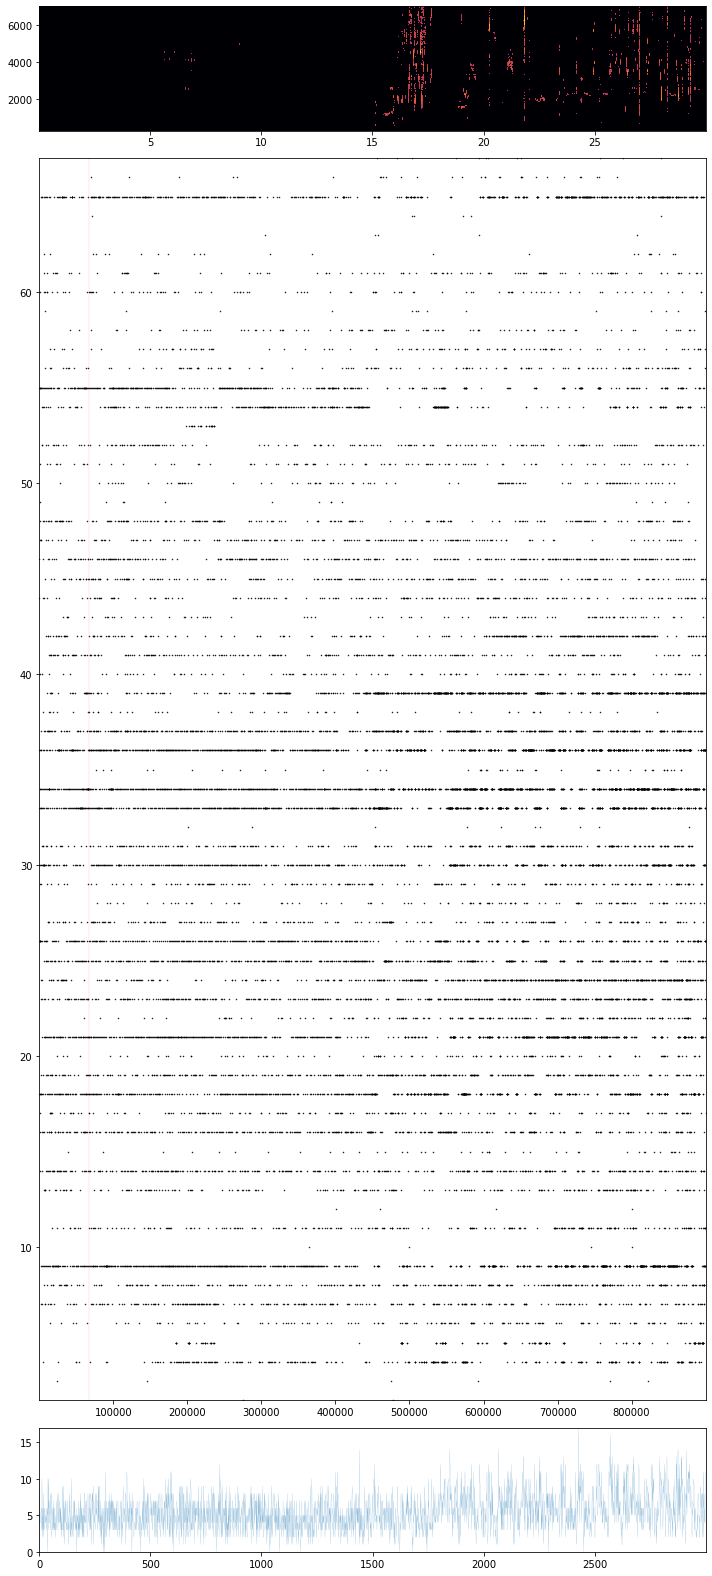

In [205]:
#### what to plot
# pick units
clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='mua') & (clu_df['nucleus'].isin(['hvc', 'ra'])), 
                                'cluster_id'])

#pick window around a bout
t_pre = - 15
t_post = 15

s_f_ap = run_recordings['ap_0']._s_f_0
t_pre_samp = int(t_pre * s_f_ap)
t_post_samp = int(t_post * s_f_ap)


##Pick a bout
bout_idx = 0
start_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(run_recordings['ap_0']._s_f_0 * t_pre)
end_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(run_recordings['ap_0']._s_f_0 * t_post)

start_nidq = bout_dict['start_sample_nidq'][bout_idx] + int(run_recordings['nidq']._s_f_0 * t_pre)
end_nidq = bout_dict['start_sample_nidq'][bout_idx] + int(run_recordings['nidq']._s_f_0 * t_post)


# get the streams/spike array
spk_arr = get_window_spikes(spk_df, clu_list, int(start_ap), int(end_ap))
mic_arr = mic_stream[0, start_nidq: end_nidq]


# plot
# plot
fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 10, 1]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), nidq_sf)

#ax[0].plot(mic_arr.flatten())

ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')

plot_as_raster(spk_arr, t_0=int(-pre_sec*ap_sf), ax=ax[1])

bin_size_ms = 10
bin_size_sample = int(bin_size_ms * 0.001 *  run_recordings['ap_0']._s_f_0 )
psth = np.nansum(pu.coarse(spk_arr, bin_size_sample), axis=0)

ax[2].plot(psth);

plt.tight_layout()

In [164]:
fig_path = os.path.join(exp_struct['folders']['derived'], 'bout_1_raster_mua')
fig.savefig(fig_path+'.png')
fig.savefig(fig_path+'.eps')

{'template': memmap([ -275,  -258,  -245, ..., -1737, -1734, -1750], dtype=int16),
 's_f': 20000,
 's_f_nidq': 19999.75,
 's_f_ap_0': 30000.0,
 'start_ms': array([   15670,    64840,   111020,   179460,   283670,   369580,
          412450,   463160,  1327100,  1375900,  1422920,  1476900,
         1512130,  1585770,  1625000,  1909140,  1970400,  2019310,
         2653600,  2767500,  3010180,  3130470,  3213900,  3274500,
         3331000,  3383830,  3447100,  3849700,  3878390,  3919670,
         3973890,  4028380,  4136000,  4227180,  4321500,  4993970,
         5110290,  5263800,  5439420,  5560350,  6410950,  6718500,
         6771670, 16330800, 16385500, 17007440, 17237000, 17388300]),
 'len_ms': array([37010, 29739, 35610, 37030, 29449, 28370, 33170, 28939, 34000,
        32719, 34079, 24199, 27209, 25860, 25789, 40589, 34500, 37289,
        32000, 48920, 31970, 51390, 30639, 30679, 33000, 29869, 29200,
        27420, 20510, 32029, 31910, 35039, 44199, 42769, 41720, 43279,
     

### Now the end of the bout

<ipython-input-206-cba613fcbe59>:42: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')
/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/plotutil.py:66: RuntimeWarning: Mean of empty slice
  coarse_x = np.nanmean(exploded_x, axis=-1)


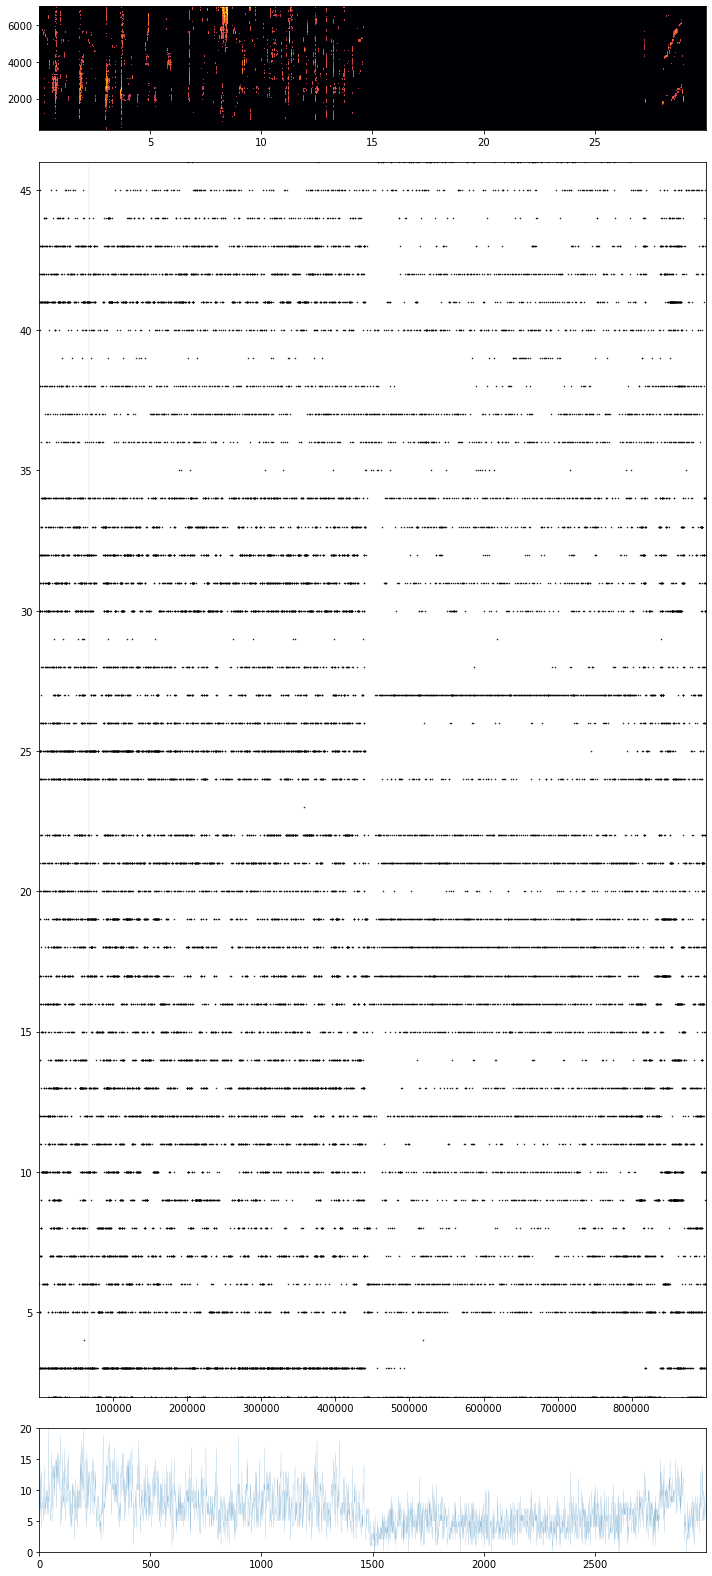

In [206]:
#### what to plot
# pick units
clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['nucleus'].isin(['hvc', 'ra'])), 
                                'cluster_id'])

#pick window around a bout
t_pre = - 15
t_post = 15

s_f_ap = run_recordings['ap_0']._s_f_0
t_pre_samp = int(t_pre * s_f_ap)
t_post_samp = int(t_post * s_f_ap)


##Pick a bout
bout_idx = 0
len_bout_s = bout_dict['len_ms'][bout_idx]/1000

#shift everything to the end of the bout
t_pre += len_bout_s
t_post += len_bout_s

start_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(run_recordings['ap_0']._s_f_0 * t_pre)
end_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(run_recordings['ap_0']._s_f_0 * t_post)

start_nidq = bout_dict['start_sample_nidq'][bout_idx] + int(run_recordings['nidq']._s_f_0 * t_pre)
end_nidq = bout_dict['start_sample_nidq'][bout_idx] + int(run_recordings['nidq']._s_f_0 * t_post)


# get the streams/spike array
spk_arr = get_window_spikes(spk_df, clu_list, int(start_ap), int(end_ap))
mic_arr = mic_stream[0, start_nidq: end_nidq]


# plot
fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 10, 1]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), nidq_sf)

#ax[0].plot(mic_arr.flatten())

ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')

plot_as_raster(spk_arr, t_0=int(-pre_sec*ap_sf), ax=ax[1])

bin_size_ms = 10
bin_size_sample = int(bin_size_ms * 0.001 *  run_recordings['ap_0']._s_f_0 )
psth = np.nansum(pu.coarse(spk_arr, bin_size_sample), axis=0)

ax[2].plot(psth);

plt.tight_layout()

## Now an entire bout

<ipython-input-276-43d440bae3c5>:44: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')
/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/plotutil.py:66: RuntimeWarning: Mean of empty slice
  coarse_x = np.nanmean(exploded_x, axis=-1)


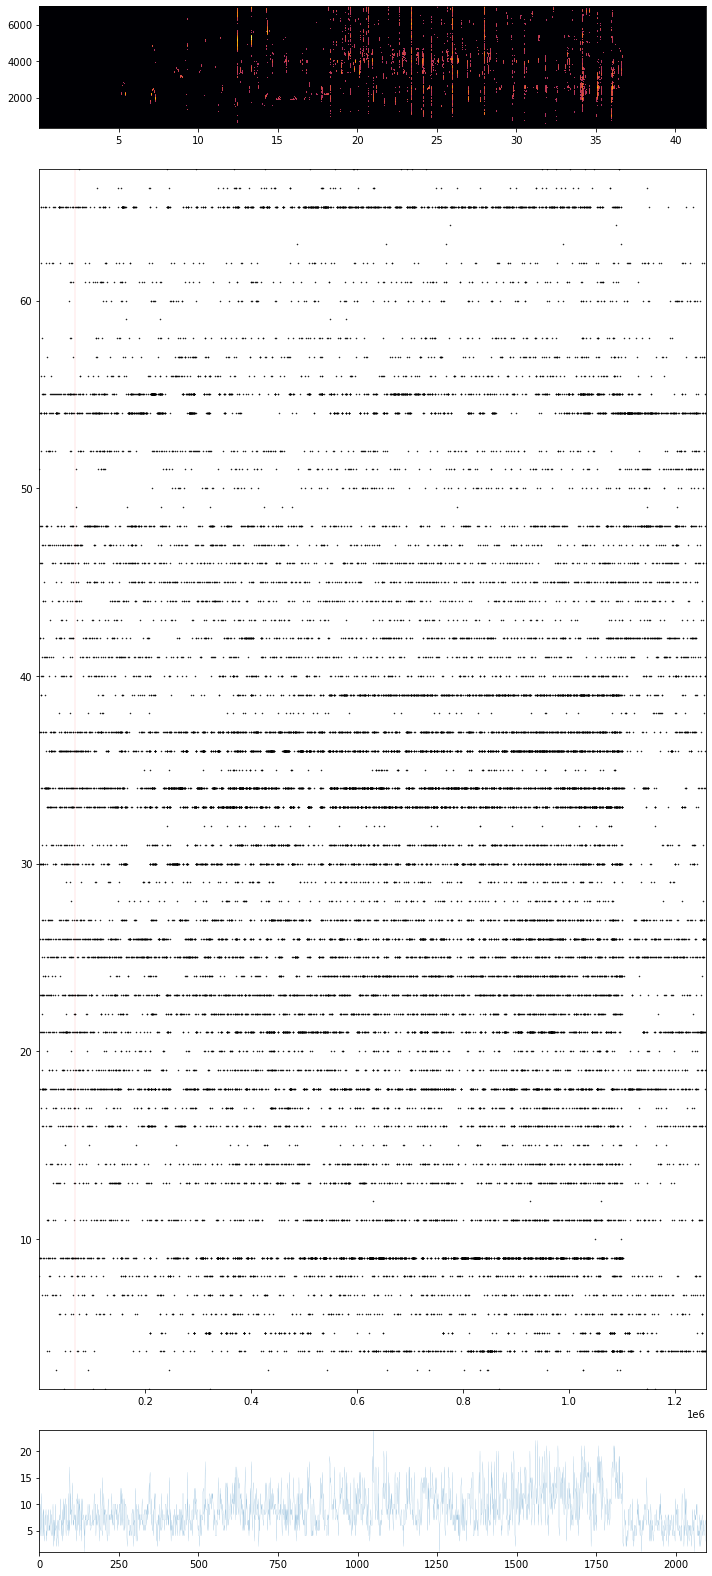

In [276]:
#### what to plot
# pick units
clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='mua') & (clu_df['nucleus'].isin(['hvc', 'ra'])), 
                                'cluster_id'])

##Pick a bout
bout_idx = 30
len_bout_s = bout_dict['len_ms'][bout_idx]/1000

#pick window around a bout
t_pre = - 5
t_post = 5

s_f_ap = run_recordings['ap_0']._s_f_0
t_pre_samp = int(t_pre * s_f_ap)

t_post_samp = int(t_post * s_f_ap)


#shift t_post to the end of the bout
t_pre += 0
t_post += len_bout_s

# get overall start/end
start_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(run_recordings['ap_0']._s_f_0 * t_pre)
end_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(run_recordings['ap_0']._s_f_0 * t_post)

start_nidq = bout_dict['start_sample_nidq'][bout_idx] + int(run_recordings['nidq']._s_f_0 * t_pre)
end_nidq = bout_dict['start_sample_nidq'][bout_idx] + int(run_recordings['nidq']._s_f_0 * t_post)


# get the streams/spike array
spk_arr = get_window_spikes(spk_df, clu_list, int(start_ap), int(end_ap))
mic_arr = mic_stream[0, start_nidq: end_nidq]


# plot
fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 10, 1]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), nidq_sf)

#ax[0].plot(mic_arr.flatten())

ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')

plot_as_raster(spk_arr, t_0=int(-pre_sec*ap_sf), ax=ax[1])

bin_size_ms = 20
bin_size_sample = int(bin_size_ms * 0.001 *  run_recordings['ap_0']._s_f_0 )
psth = np.nansum(pu.coarse(spk_arr, bin_size_sample), axis=0)

ax[2].plot(psth);

plt.tight_layout()

In [211]:
fig_path = os.path.join(exp_struct['folders']['derived'], 'bout_1-complete-mua')
fig.savefig(fig_path+'.png')
fig.savefig(fig_path+'.eps')

In [136]:
mic_arr.shape

(0,)

In [277]:
### view mean and variance
psth = np.nansum(pu.coarse(spk_arr, bin_size_sample), axis=0)
pstv = np.nanstd(pu.coarse(spk_arr, bin_size_sample), axis=0)

#plt.plot(psth)
pstv

/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/plotutil.py:66: RuntimeWarning: Mean of empty slice
  coarse_x = np.nanmean(exploded_x, axis=-1)


array([0., 0., 0., ..., 0., 0., 0.])

### save cluster, motif and cluster metadata

In [212]:
import pickle

In [99]:
clu_df_path = os.path.join(exp_struct['folders']['derived'], 'clu_df.pkl')
clu_df.to_pickle(clu_df_path)

spk_df_path = os.path.join(exp_struct['folders']['derived'], 'spk_df.pkl')
spk_df.to_pickle(spk_df_path)

mot_dict_path = os.path.join(exp_struct['folders']['derived'], 'mot_dict.pkl')
with open(mot_dict_path, 'wb') as handle:
    pickle.dump(bout_dict, handle)


NameError: name 'clu_df' is not defined

In [174]:
exp_struct['folders']['processed']

'/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/processed/20201104/2500r250a_3500_dir_g0'

In [161]:
bin_spk_arr.shape

(169, 1250)

### try the pca decomposition

In [216]:
### first, collect all the bouts
clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['nucleus'].isin(['hvc', 'ra'])), 
                                'cluster_id'])

def collect_bout(bout_idx, bout_dict, clu_list, spk_df, t_pre=-5, t_post=5):
    
    ##Pick a bout
    len_bout_s = bout_dict['len_ms'][bout_idx]/1000

    #shift t_post to the end of the bout
    t_pre += 0
    t_post += len_bout_s

    # get overall start/end
    start_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(run_recordings['ap_0']._s_f_0 * t_pre)
    end_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(run_recordings['ap_0']._s_f_0 * t_post)

    start_nidq = bout_dict['start_sample_nidq'][bout_idx] + int(run_recordings['nidq']._s_f_0 * t_pre)
    end_nidq = bout_dict['start_sample_nidq'][bout_idx] + int(run_recordings['nidq']._s_f_0 * t_post)

    # get the streams/spike array
    spk_arr = get_window_spikes(spk_df, clu_list, int(start_ap), int(end_ap))
    mic_arr = mic_stream[0, start_nidq: end_nidq]
    
    return spk_arr, mic_arr


spka, mica = collect_bout(0, bout_dict, clu_list, spk_df, t_pre=-5, t_post=5)

In [222]:
bout_dict['start_ms'].size

48

In [223]:
## collect all spikes from all bouts
all_spk_list = [collect_bout(i, bout_dict, clu_list, spk_df, t_pre=-5, t_post=5)[0] for i in range(bout_dict['start_ms'].size)]

In [227]:
bin_size_ms = 10
bin_size_sample = int(bin_size_ms * 0.001 *  run_recordings['ap_0']._s_f_0 )

all_spk_list = [pu.coarse(x, bin_size_sample) for x in all_spk_list]

In [228]:
all_spk_list[0].shape

(66, 4701)

In [233]:
bin_spk_arr = np.concatenate(all_spk_list, axis=1)

In [232]:
all_spk_arr.shape

(66, 214109)

In [258]:
from sklearn import decomposition 
# get the pca
pca_ra = decomposition.PCA(n_components=2)


pc_ra = pca_ra.fit_transform(bin_spk_arr.T)


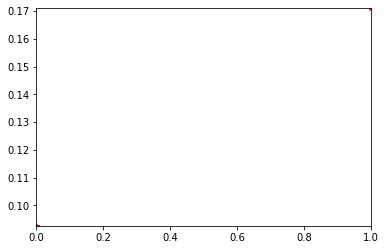

In [259]:
plt.plot(pca_ra.explained_variance_ratio_.cumsum(), 'r*')

### pick a bout and do the trajectory

In [260]:
i_bout = 0

spk_bout_arr = all_spk_list[i_bout]

pc_bout = pca_ra.transform(spk_bout_arr.T)

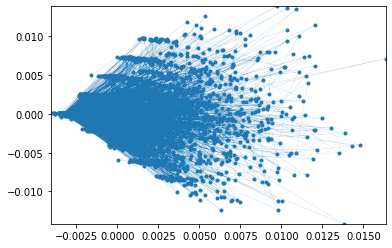

In [261]:
plt.plot(*pc_bout.T, '.-')

In [253]:
pc_bout.shape

(4701, 10)

In [251]:
spk_bout_arr.shape

(66, 4701)

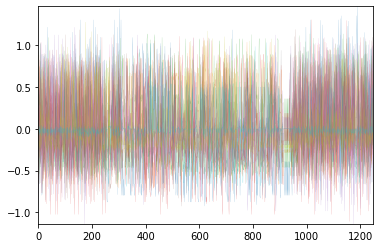

In [399]:
plt.plot(pc_hvc)

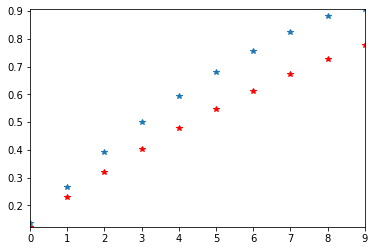

In [401]:
plt.plot(pca_ra.explained_variance_ratio_.cumsum(), 'r*')
plt.plot(pca_hvc.explained_variance_ratio_.cumsum(), '*')

In [381]:
pca_hvc.explained_variance_ratio_.cumsum()

array([0.13821702, 0.26647582, 0.39093754, 0.49862427, 0.59246108,
       0.67937757, 0.75698878, 0.82434353, 0.88032961, 0.90594687])

<ipython-input-195-ca374ab1f158>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')


<AxesSubplot:>

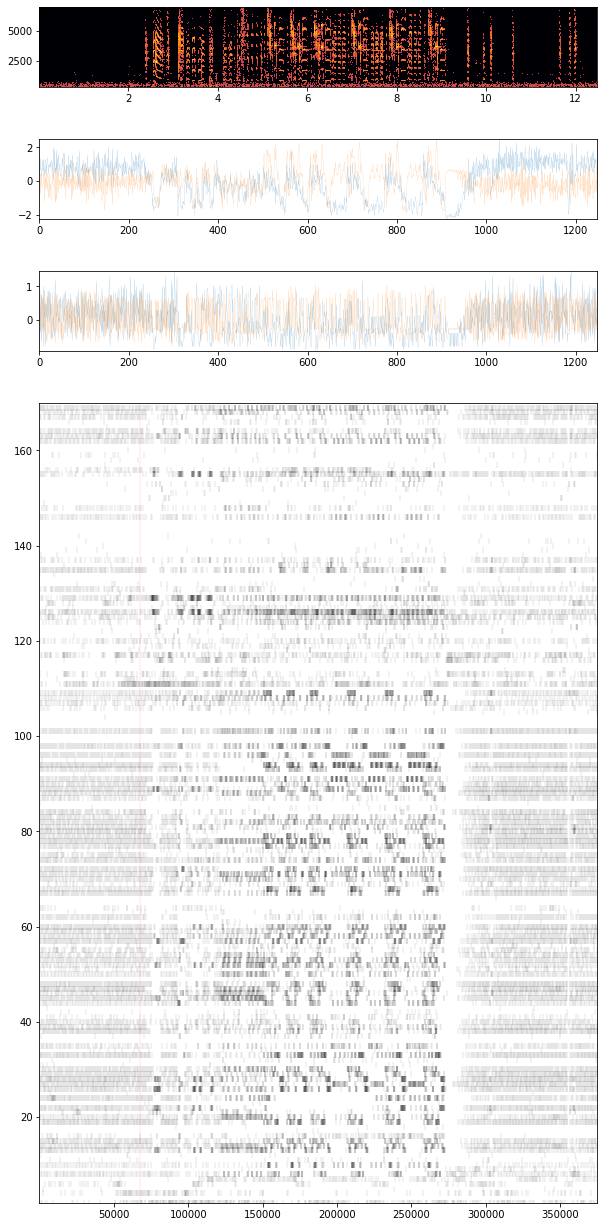

In [195]:
spk_arr = get_window_spikes(spk_df, clu_list, int(ap_start + pre_sec*ap_sf), int(ap_start + post_sec*ap_sf))

fig, ax = plt.subplots(nrows=4, gridspec_kw={'height_ratios': [1, 1, 1, 10]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), nidq_sf)


ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')

ax[1].plot(pc_ra)
ax[2].plot(pc_hvc)


pu.plot_as_raster(spk_arr, t_0=int(-pre_sec*ap_sf), ax=ax[3])



In [214]:
pc_ra.shape

(1250, 2)

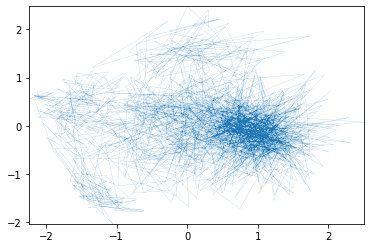

In [367]:
plt.plot(*pc_ra[:,:].T, '-')

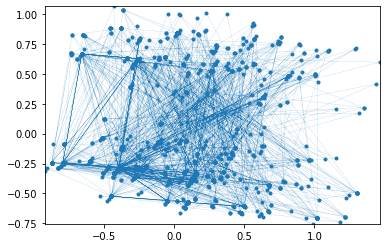

In [275]:
plt.plot(*pc_hvc.T, '.-')

In [ ]:
### TODO
- NMF factorization
- color code the time
- look at it on a motif 
- shuffle each cell spike train inependently in time


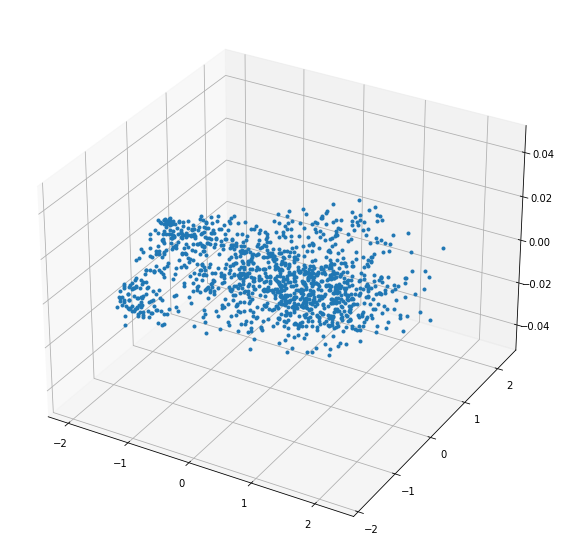

In [281]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(*pc_ra.T, '-.')

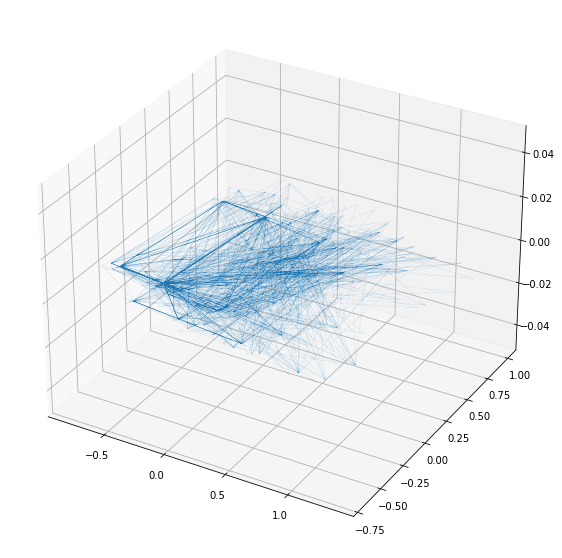

In [282]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(*pc_hvc.T, '-.')

In [137]:
spk_arr = get_window_spikes(spk_df, clu_list, int(ap_start + pre_sec*ap_sf), int(ap_start + post_sec*ap_sf))

fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 1, 10]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), nidq_sf)

ax[0].plot(mic_arr.flatten())

ax[1].pcolormesh(t, f, np.log(sxx), cmap='inferno')

pu.plot_as_raster(spk_arr, t_0=int(-pre_sec*ap_sf), ax=ax[2])

(139, 139)

<ipython-input-108-4f6b49285573>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[1].pcolormesh(t, f, np.log(sxx), cmap='inferno')


<AxesSubplot:>

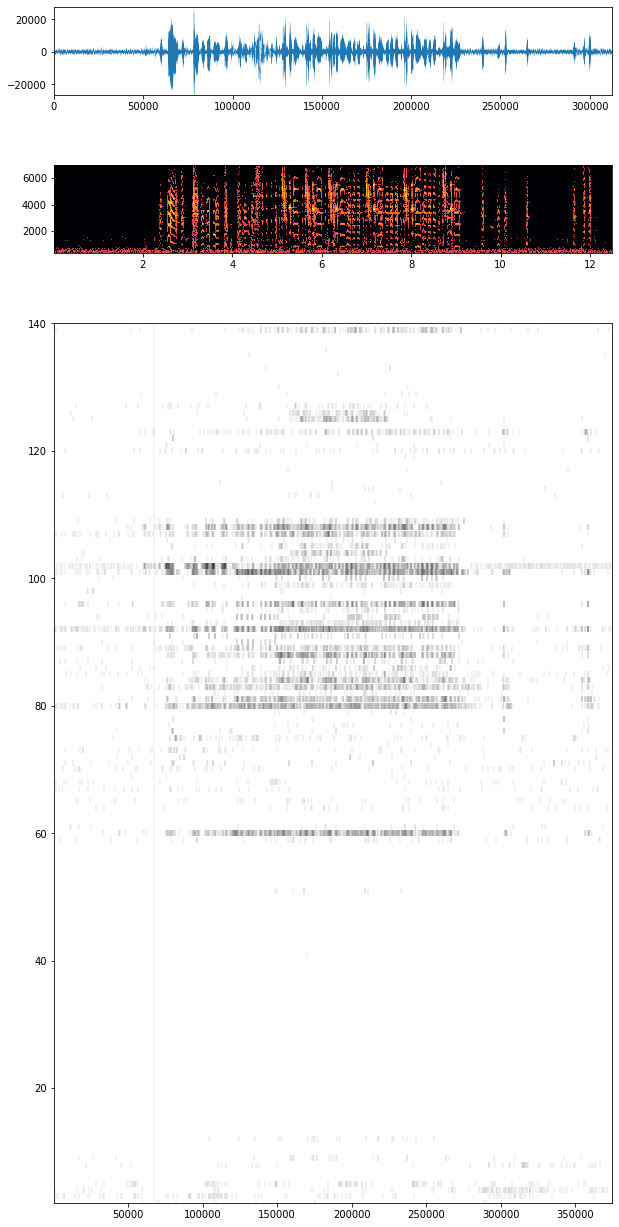

In [108]:
mua_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='mua') & (clu_df['nucleus'].isin(['hvc', 'ra'])), 
                                'cluster_id'])

spk_arr = get_window_spikes(spk_df, mua_list, int(ap_start + pre_sec*ap_sf), int(ap_start + post_sec*ap_sf))

fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 1, 10]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), nidq_sf)

ax[0].plot(mic_arr.flatten())

ax[1].pcolormesh(t, f, np.log(sxx), cmap='inferno')

pu.plot_as_raster(spk_arr, t_0=int(-pre_sec*ap_sf), ax=ax[2])

In [95]:
spk_arr.shape

(169, 375001)

In [635]:
clu_df.head(1)

,cluster_id,KSLabel,template,max_chans,main_chan,main_7,main_wav_7,nucleus
0,0,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0, 2, 1, 3, 4, 5, 23, 25, 21, 24, 18, 17, 10,...",0,"[0, 1, 2, 3, 4, 5, 23]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",NaN


In [106]:
clu_df['KSLabel']

0      good
1      good
5      good
7      good
14     good
       ... 
808     mua
813     mua
814     mua
807     mua
815     mua
Name: KSLabel, Length: 1077, dtype: object

In [639]:
clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['nucleus'].isin(['hvc', 'ra'])),:]

,cluster_id,KSLabel,template,max_chans,main_chan,main_7,main_wav_7,nucleus
170,170,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[50, 48, 49, 51, 52, 54, 47, 46, 53, 44, 55, 5...",50,"[47, 48, 49, 50, 51, 52, 54]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",ra
176,176,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[50, 52, 49, 51, 48, 56, 47, 46, 53, 43, 54, 5...",50,"[47, 48, 49, 50, 51, 52, 56]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",ra
179,179,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[51, 49, 48, 45, 47, 53, 57, 52, 50, 55, 43, 4...",51,"[45, 47, 48, 49, 51, 53, 57]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",ra
180,180,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[51, 52, 48, 49, 50, 46, 53, 54, 45, 47, 44, 6...",51,"[46, 48, 49, 50, 51, 52, 53]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",ra
181,181,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[51, 52, 50, 53, 49, 54, 56, 57, 48, 55, 46, 4...",51,"[49, 50, 51, 52, 53, 54, 56]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",ra
...,...,...,...,...,...,...,...,...
997,997,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[310, 311, 312, 308, 305, 309, 313, 307, 314, ...",310,"[305, 308, 309, 310, 311, 312, 313]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",hvc
777,777,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[313, 311, 309, 308, 312, 307, 317, 315, 306, ...",313,"[307, 308, 309, 311, 312, 313, 317]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",hvc
778,778,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[314, 316, 312, 317, 313, 319, 315, 321, 310, ...",314,"[312, 313, 314, 315, 316, 317, 319]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",hvc
782,782,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[318, 317, 316, 319, 314, 323, 321, 324, 312, ...",318,"[314, 316, 317, 318, 319, 321, 323]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",hvc


In [ ]:
clu_list = np.unique(clu_df.loc[clu_df['KSLabel']=='good', 'cluster_id'])

In [648]:
### get window spikes for ra/hvc during the bout
clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['nucleus'].isin(['hvc', 'ra'])), 'cluster_id'])

#spk_arr = get_window_spikes(spk_df, clu_list, ap_samples[0] + t_pre_samp, ap_samples[0] + t_post_samp)

In [649]:
clu_list

array([ 170,  176,  179,  180,  181,  182,  183,  184,  186,  187,  188,
        189,  190,  191,  194,  197,  198,  199,  200,  204,  205,  206,
        208,  210,  211,  212,  214,  215,  217,  218,  219,  221,  226,
        229,  230,  232,  233,  236,  237,  238,  239,  242,  243,  244,
        245,  249,  253,  254,  255,  256,  259,  261,  262,  263,  264,
        266,  269,  270,  271,  272,  275,  276,  277,  278,  279,  280,
        281,  284,  286,  287,  288,  289,  290,  293,  294,  300,  301,
        302,  303,  304,  306,  307,  308,  309,  313,  314,  316,  317,
        318,  319,  320,  322,  323,  326,  327,  328,  331,  333,  334,
        335,  336,  337,  338,  340,  342,  343,  344,  345,  346,  347,
        348,  727,  731,  732,  734,  735,  739,  740,  741,  742,  746,
        747,  757,  762,  777,  778,  782,  783,  854,  855,  857,  858,
        859,  860,  862,  864,  865,  868,  869,  871,  872,  874,  875,
        876,  877,  878,  879,  880,  984,  985,  9

In [399]:
t_pre_samp

-12499

In [400]:
rast_arr.shape

(593, 49998, 10)

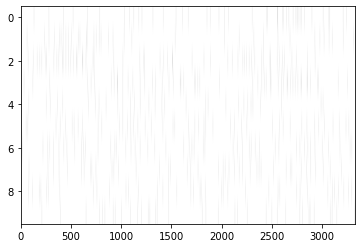

In [401]:
def coarse(x: np.ndarray, n_coarse: int):
    # coarse x along last dimension in bins of n_coarse size
    x_shape = x.shape
    last_dim = x.shape[-1]
    
    max_n = last_dim//n_coarse * n_coarse # chop it to the max integer coarse
    exploded_x = x[..., :max_n].reshape(*x_shape[:-1], -1, n_coarse)
    coarse_x = exploded_x.mean(axis=-1)
    return coarse_x

### get it in miliseconds
samples_in_ms = int(run_recordings['ap_0']._s_f_0 * 0.001)
samples_in_ms


clu_idx =  6 ##idx of the clu in the array
one_raster_ms = coarse(rast_arr[clu_idx].T, samples_in_ms//2)

one_raster_ms[one_raster_ms>0] = 1
one_raster_ms[one_raster_ms<0] = -1

plt.imshow((one_raster_ms[::-1]), aspect='auto', cmap='Greys')

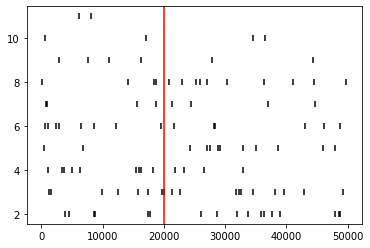

In [402]:
def plot_as_raster(x, ax=None, t_0=None):
    #x is [n_events, n_timestamps] array
    n_y, n_t = x.shape
    
    row = np.ones(n_t) + 1
    t = np.arange(n_t)
    col = np.arange(n_y)
    
    frame = col[:, np.newaxis] + row[np.newaxis, :]
    x[x==0] = np.nan
    
    if ax is None:
        fig, ax = plt.subplots()
    
    raster = ax.scatter(t * x, frame * x, marker='|', facecolor='k', rasterized=True)
    if t_0 is not None:
        ax.axvline(x=t_0, color='red')
    return ax

clu_idx = 105
ax = plot_as_raster(rast_arr[clu_idx].T, t_0=20000)

IndexError: index 200 is out of bounds for axis 0 with size 169

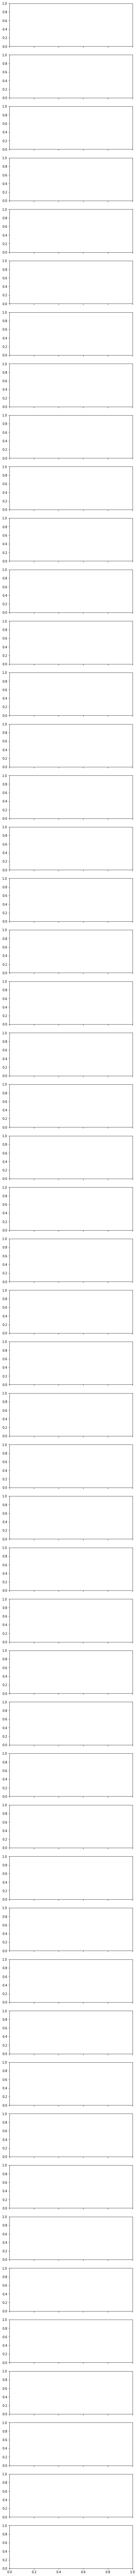

In [294]:
#### plot 50 rasters
fig, ax_arr = plt.subplots(nrows=50, figsize=[7, 150], sharex=True)

for i_rast, clu_idx in enumerate(range(200, 250)):    
    #one_raster_ms = coarse(rast_arr[clu_idx].T, samples_in_ms)
    #plt.imshow(one_raster_ms[::-1], aspect='auto', cmap='inferno')
    plot_as_raster(rast_arr[clu_idx].T, t_0=20000, ax=ax_arr[i_rast])

In [404]:
np.nansum(one_raster_ms)

433.0

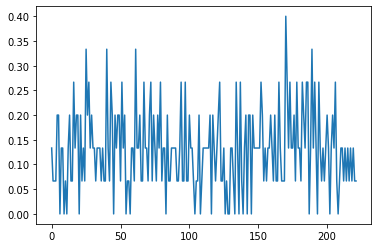

In [405]:
plt.plot(coarse(np.nansum(one_raster_ms, axis=0), 15))

In [279]:
np.stack(spk_arr_list, axis=-1).shape

(593, 10, 15000)

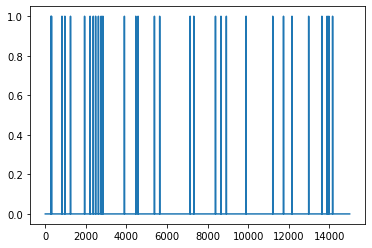

In [292]:
plt.plot(rast_arr[clu_idx].sum(axis=1))

In [293]:
rast_arr[clu_idx].shape

(15000, 10)

In [285]:
one_raster_ms

array([], shape=(15000, 0), dtype=float64)

<ipython-input-280-0df3c8c7bcdc>:1: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(one_raster_ms[::-1], aspect='auto', cmap='inferno')


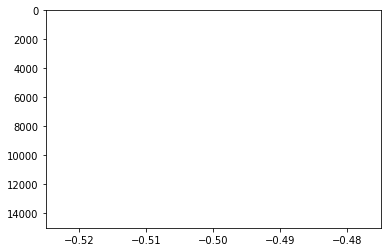

In [280]:
plt.imshow(one_raster_ms[::-1], aspect='auto', cmap='inferno')

In [270]:
spk_arr.shape

(593, 4000)

In [269]:
clu_list

array([   0,    1,    5,    7,   13,   14,   16,   17,   18,   21,   22,
         23,   25,   26,   27,   28,   30,   32,   34,   35,   36,   40,
         42,   43,   44,   46,   47,   49,   51,   52,   53,   56,   57,
         58,   59,   62,   63,   64,   65,   68,   69,   70,   71,   74,
         75,   77,   78,   80,   82,   83,   87,   88,   90,   91,   92,
         95,   96,   97,   98,   99,  102,  103,  104,  105,  106,  109,
        110,  111,  113,  114,  115,  117,  118,  121,  123,  124,  128,
        129,  130,  132,  135,  136,  137,  138,  140,  141,  142,  143,
        144,  145,  146,  150,  151,  152,  153,  155,  157,  158,  159,
        160,  161,  162,  165,  166,  167,  168,  170,  176,  179,  180,
        181,  182,  183,  184,  186,  187,  188,  189,  190,  191,  194,
        197,  198,  199,  200,  204,  205,  206,  208,  210,  211,  212,
        214,  215,  217,  218,  219,  221,  226,  229,  230,  232,  233,
        236,  237,  238,  239,  242,  243,  244,  2

In [198]:
loaded_sort.get_unit_property_names(5)

['Amplitude', 'ContamPct', 'KSLabel', 'quality']

In [206]:
loaded_sort.get_unit_property(5, 'KSLabel')

'good'

In [207]:
loaded_sort.get_units_spike_train([5])

[array([   101649,    285124,    285299, ..., 229055603, 229230185,
        229235620], dtype=uint64)]

In [ ]:
loaded_sort.get_unit_property(5, 'KSLabel')

In [101]:
u_wf = st.postprocessing.get_unit_waveforms(ap_extractor_filt, loaded_sort, unit_ids=[0, 1], 
                                            ms_before=0.5, ms_after=0.5,
                                          save_as_features=True, verbose=True,
                                           **{'n_jobs': 40,
                                           'max_spikes_per_unit': 100})

Number of chunks: 14087 - Number of jobs: 40


In [106]:
u_wf[0].shape

(100, 384, 28)

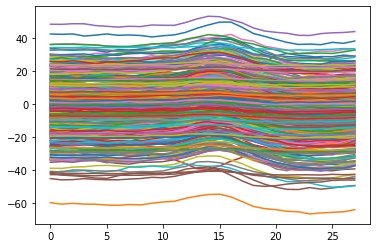

In [111]:
plt.plot(u_wf[1].mean(axis=0).T);

In [115]:
u_wf = st.postprocessing.get_unit_max_channels(ap_extractor_filt, loaded_sort, unit_ids=[0, 1], 
                                            ms_before=0.5, ms_after=0.5,
                                          save_as_features=True, verbose=True,
                                           **{'n_jobs': 40,
                                           'max_spikes_per_unit': 100})

Number of chunks: 14087 - Number of jobs: 40
Number of chunks: 14087 - Number of jobs: 40


In [98]:
all_unit_id = np.array(loaded_sort.get_unit_ids())

In [99]:
loaded_sort.get_unit_property(5, 'pc_features')

ValueError: pc_features has not been added to unit 5

In [119]:
u_wf

[0, 0]

In [116]:
loaded_sort.get_shared_unit_spike_feature_names(unit_ids=[0,1])

['amplitudes', 'pc_features', 'waveforms', 'waveforms_idxs']

In [54]:
snrs = st.validation.compute_snrs(loaded_sort, ap_extractor)


In [56]:
isi_violations = st.validation.compute_isi_violations(loaded_sort, 
                                                      duration_in_frames=ap_extractor.get_num_frames())

In [58]:
wf = st.postprocessing.get_unit_waveforms(ap_extractor, loaded_sort, ms_before=1, ms_after=2,
                                          save_as_features=True, verbose=True)

In [60]:
wf[0].shape

(1000, 384, 178)

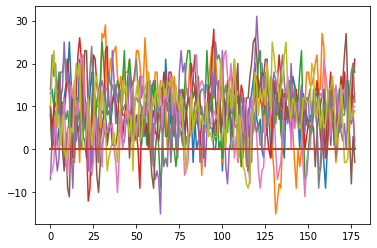

In [86]:
plt.plot(wf[13][:, 0, :].T);

In [72]:
max_chan = st.postprocessing.get_unit_max_channels(ap_extractor, loaded_sort, save_as_property=True, verbose=True)

In [86]:
templates = st.postprocessing.get_unit_templates(ap_extractor, loaded_sort, save_as_property=True, verbose=True)

Number of chunks: 353 - Number of jobs: 1


KeyboardInterrupt: 

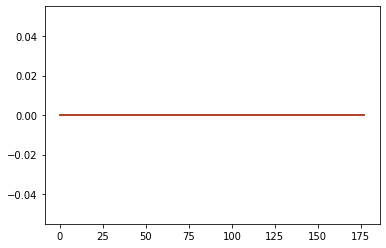

In [90]:
plt.plot(templates[0].T);

In [78]:
np.where(np.array(max_chan)>0)

(array([  5,  13,  23,  36,  44,  59,  72,  73,  84, 117, 126, 200, 250,
        259]),)

In [85]:
loaded_sort.get_unit_property(15, 'max_channel')

ValueError: max_channel has not been added to unit 15

### load the npy objects from kilosort

In [92]:
spk_clu = np.load(os.path.join(tmp_loc, 'tmp_ks2', 'spike_clusters.npy'))
spk_templates = np.load(os.path.join(tmp_loc, 'tmp_ks2', 'templates.npy'))

In [97]:
np.unique(spk_clu).shape

(272,)

In [93]:
spk_templates.shape

(314, 82, 371)

## Try with sglexp
make a pandas dataframe to keep track of epochs (folders), runs within each session, caryying the recording extractors

In [122]:
from ceciestunepipe.util import sglxexp as sgle

In [126]:
reload(sgle)
epoch_pd = sgle.make_sgl_epoch_dict(sess_par, sess_epochs[1])

In [127]:
epoch_pd

,bird,sess,run,nidq,lf_0,ap_0,rec-nidq,rec-lf_0,rec-ap_0
0,z_w12m7_20,20201104,0,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,<ceciestunepipe.util.spikeextractors.extractor...,<ceciestunepipe.util.spikeextractors.extractor...,<ceciestunepipe.util.spikeextractors.extractor...


In [138]:
reload(sgle)
sess_pd = sgle.make_session_pd(sess_par)
sess_pd

2021-01-28 11:52:14,246 ceciestunepipe.util.sglxutil INFO     {'folders': {'bird': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20', 'raw': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104', 'kwik': '/mnt/sphere/earneodo/bci_zf/ss_data/z_w12m7_20/Ephys/kwik/20201104', 'processed': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/processed/20201104', 'tmp': '/scratch/earneodo/tmp/tmp', 'msort': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/msort/20201104', 'ksort': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104'}, 'files': {'par': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104/params.json', 'set': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/settings.isf', 'rig': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/rig.json', 'kwd': '/mnt/sphere/earneodo/bci_zf/ss_data/z_w12m7_20/Ephys/kwik/20201104/stream.kwd', 'kwik': '/mnt/sphere/earneodo/bci_zf/ss_data/z_w12m7_20/Ephys/kwik/20201104/sort_2/

,bird,sess,epoch,run,nidq,lf_0,ap_0,rec-nidq,rec-lf_0,rec-ap_0
0,z_w12m7_20,20201104,2500r250a_3500_dir_g0,0,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,<ceciestunepipe.util.spikeextractors.extractor...,<ceciestunepipe.util.spikeextractors.extractor...,<ceciestunepipe.util.spikeextractors.extractor...
1,z_w12m7_20,20201104,2500r250a_3500_dir_g1,0,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,<ceciestunepipe.util.spikeextractors.extractor...,<ceciestunepipe.util.spikeextractors.extractor...,<ceciestunepipe.util.spikeextractors.extractor...
2,z_w12m7_20,20201104,2500r250a_3500_dir_g2,0,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,<ceciestunepipe.util.spikeextractors.extractor...,<ceciestunepipe.util.spikeextractors.extractor...,<ceciestunepipe.util.spikeextractors.extractor...


### get some metadata

In [137]:
def get_sess_pd_meta(sess_pd: pd.DataFrame) -> pd.DataFrame:
    # fields to pick from the sglx metadata
    sglx_fields = {}
    

,bird,sess,epoch,run,nidq,lf_0,ap_0,rec-nidq,rec-lf_0,rec-ap_0
0,z_w12m7_20,20201104,2500r250a_3500_dir_g0,0,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,<ceciestunepipe.util.spikeextractors.extractor...,<ceciestunepipe.util.spikeextractors.extractor...,<ceciestunepipe.util.spikeextractors.extractor...
1,z_w12m7_20,20201104,2500r250a_3500_dir_g1,0,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,<ceciestunepipe.util.spikeextractors.extractor...,<ceciestunepipe.util.spikeextractors.extractor...,<ceciestunepipe.util.spikeextractors.extractor...
2,z_w12m7_20,20201104,2500r250a_3500_dir_g2,0,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,<ceciestunepipe.util.spikeextractors.extractor...,<ceciestunepipe.util.spikeextractors.extractor...,<ceciestunepipe.util.spikeextractors.extractor...


### sort a merged recording extractor with all of the session epochs, runs

In [193]:
def merge_pd(sess_pd: pd.DataFrame) -> pd.DataFrame:
    
    # get the list of existing recordings (one per stream)
    rec_list = [c for c in (sess_pd.columns) if 'rec' in c]
    
    # merge each column
    merged_rec_dict = {c: se.MultiRecordingTimeExtractor(recordings=list(sess_pd.loc[:, c].values)) for c in rec_list}
    
    merged_pd = pd.DataFrame.from_dict(merged_rec_dict, orient='index').T
    merged_pd['bird'] = sess_pd['bird']
    merged_pd['sess'] = sess_pd['sess']
    merged_pd['epoch'] = [list(sess_pd.loc[:, 'epoch'].values)]*len(merged_pd)
    merged_pd['run'] = [list(sess_pd.loc[:, 'run'].values)]*len(merged_pd)
    
    return merged_pd

reload(sgle)
merged_pd = sgle.merge_session_pd(sess_pd)

In [194]:
merged_pd

,rec-nidq,rec-lf_0,rec-ap_0,bird,sess,epoch,run
0,<spikeextractors.multirecordingtimeextractor.M...,<spikeextractors.multirecordingtimeextractor.M...,<spikeextractors.multirecordingtimeextractor.M...,z_w12m7_20,20201104,"[2500r250a_3500_dir_g0, 2500r250a_3500_dir_g1,...","[0, 0, 0]"


In [195]:
merged_pd.loc[0, 'rec-lf_0']

In [197]:
merged_exp_struct = sglu.sgl_struct(sess_par, 'merge')
merged_exp_struct

{'folders': {'bird': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/merge',
  'raw': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/merge',
  'kwik': '/mnt/sphere/earneodo/bci_zf/ss_data/z_w12m7_20/Ephys/kwik/20201104/merge',
  'processed': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/processed/20201104/merge',
  'tmp': '/scratch/earneodo/tmp/tmp/merge',
  'msort': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/msort/20201104/merge',
  'ksort': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104/merge'},
 'files': {'par': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104/merge/params.json',
  'set': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/settings.isf',
  'rig': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/rig.json',
  'kwd': '/mnt/sphere/earneodo/bci_zf/ss_data/z_w12m7_20/Ephys/kwik/20201104/merge/stream.kwd',
  'kwik': '/mnt/sphere/earneodo/bci_zf/ss_data/z_w12m7_20/Ephys/kwik/202

In [198]:
tmp_loc

'/scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104/2500r250a_3500_dir_g2'

In [ ]:
sort_pickle_path = os.path.join(merged_exp_struct['folders']['ksort'], 'sort_ks2.pickle')
tmp_loc = merged_exp_struct['folders']['ksort']

sort = run_spikesort(merged_pd.loc[0, 'rec-ap_0'], logger, sort_pickle_path, tmp_loc, restrict_to_gpu=1, **ks2_params)

2021-01-28 23:56:25,540 root         INFO     Grouping property: None
2021-01-28 23:56:25,542 root         INFO     sorting method: kilosort2
2021-01-28 23:56:25,543 root         INFO     Sorting tmp dir /scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104/merge/tmp_ks2
2021-01-28 23:56:25,545 root         INFO     Will set visible gpu devices 1


In [80]:
sort